# 1. Projekat iz predmeta **Mašinsko učenje**
 
**Dataset:**  
[Classify hunting of a Chinese mantis](https://www.kaggle.com/datasets/stealthtechnologies/predict-hunting-success-rate-of-a-chinese-mantis)

U ovom projektu bavimo se problemom **binarne klasifikacije** u okviru mašinskog učenja, koristeći **Chinese Mantis Hunting Dataset**.
Skup podataka sadrži informacije o uslovima okoline i karakteristikama lova, na osnovu kojih se vrši predviđanje ishoda lova (uspešan ili neuspešan). 

Osobine (feature-i): <br />
**Humidity Level** - nivo vlažnosti vazduha <br/>
**Temperature** - temperatura okoline <br/>
**Time of Day** - period dana (jutro, podne, veče) <br/>
**Luring Success** - da li je plen uspešno namamljen <br />
**Time Spent Hunting** - vreme provedeno u lovu <br />
**Prey Size** - veličina plena <br />
**Ambush** - da li je lov iz zasede ili ne <br />
**Food Availability** - dostupnost hrane u okolini (niska, srednja, visoka) <br />
**Predator Presence** - prisustvo drugih predatora u okolini <br />
**Is Competition** - da li je postojala konkurencija tokom lova <br />


**Cilj**: Cilj ovog zadatka je treniranje klasifikacionog modela koji, na osnovu ulaznih karakteristika, određuje da li je lov:
- **uspešan** ili
- **neuspešan**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from lazypredict import Supervised
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn
import xgboost
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV

warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')


## **2. Analiza podataka**

#### <b>Učitavanje podataka</b>

In [2]:
dataset = pd.read_csv('../data/data.csv')

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


#### <b>Prikaz osnovnih informacija</b>

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      300000 non-null  float64
 1   Temperature         300000 non-null  float64
 2   Time of Day         300000 non-null  object 
 3   Luring Success      300000 non-null  bool   
 4   Time Spent Hunting  300000 non-null  float64
 5   Prey Size           300000 non-null  float64
 6   Ambush              300000 non-null  bool   
 7   Food Availability   269788 non-null  object 
 8   Predator Presence   270292 non-null  object 
 9   Is Competition      269881 non-null  object 
 10  Hunting Success     300000 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


<i>Zapažanja: kolone <b>Predator Presence</b> i <b>Is Competition</b> su tipa object, iako u .csv-u imaju vrednosti <b>TRUE</b> i <b>FALSE</b>. 
Pretpostavka: Fale podaci u nekim redovima za ove vrednosti. </i>


#### <b>Prikaz sumirane statistike</b>

In [4]:
dataset.describe()

,Humidity Level,Temperature,Time Spent Hunting,Prey Size,Hunting Success
count,300000.00,300000.00,300000.00,300000.00,300000.00
mean,0.60,27.50,2.73,5.66,0.55
std,0.17,4.33,1.41,2.82,0.50
min,0.30,20.00,0.40,1.00,0.00
25%,0.45,23.75,1.55,3.31,0.00
50%,0.60,27.49,2.69,5.59,1.00
75%,0.75,31.25,3.84,7.88,1.00
max,0.90,35.00,10.19,20.97,1.00


## <b> 3. Priprema skupa podataka i deskriptivna analiza </b>


### <b>3.1. Priprema podataka</b>

Analiza raspodele target varijable

In [5]:
hunting_success_dist = dataset['Hunting Success'].value_counts()
print("Raspodela Hunting Success:")
print(hunting_success_dist)
print(f"\nProcenat: {hunting_success_dist / len(dataset) * 100}")

Raspodela Hunting Success:
Hunting Success
1    164957
0    135043
Name: count, dtype: int64

Procenat: Hunting Success
1   54.99
0   45.01
Name: count, dtype: float64


<i>Zapažanje: Dataset je balansiran - obe klase su približno jednako zastupljene.</i>

Provera koliko duplikata postoji u setu podataka

In [6]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')

Broj duplikata: 0


Prikazan broj praznih vrednosti po kolonama:

In [7]:
dataset.isnull().sum()

Humidity Level            0
Temperature               0
Time of Day               0
Luring Success            0
Time Spent Hunting        0
Prey Size                 0
Ambush                    0
Food Availability     30212
Predator Presence     29708
Is Competition        30119
Hunting Success           0
dtype: int64

Procenat broja redova prema broju nedostajućih vrednosti - tabela

In [8]:
raspodela = dataset.isnull().sum(axis=1).value_counts().sort_index()
ukupan_broj_redova = len(dataset)

tabela = pd.DataFrame({
    'Broj nedostajućih vrednosti': raspodela.index,
    'Broj redova': raspodela.values,
    'Procenat (%)': (raspodela.values / ukupan_broj_redova * 100).round(2)
})

tabela


,Broj nedostajućih vrednosti,Broj redova,Procenat (%)
0,0,218592,72.86
1,1,73107,24.37
2,2,7971,2.66
3,3,330,0.11


<i>Zapažanje: Većina redova sa praznim vrednostima ima samo jednu nedefinisanu vrednost.
Može se uraditi: Procenat redova kojima fali više od jedne vrednosti je jako mali(ispod 5%) i njihovo brisanje neće značajno uticati na ishod.
Procenat redova kojima nedostaje jedna vrednost predstavlja veliki deo dataseta i treba ih sačuvati za analizu. Prazne vrednosti se mogu zameniti validnim vrednostima na sledeći način:  <br>
<b>Probabilistička imputacija</b> - Pronalaženje odnosa vrednosti TRUE/FALSE i popunjavanje dataset-a tako da se održi ova razmera - Očuvava se odnos TRUE/FALSE



Brisanje redova sa više nedefinisanih vrednosti:

In [9]:
dataset = dataset[dataset.isnull().sum(axis=1) <= 1]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  bool   
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  bool   
 7   Food Availability   267110 non-null  object 
 8   Predator Presence   267668 non-null  object 
 9   Is Competition      267212 non-null  object 
 10  Hunting Success     291699 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 22.8+ MB


Procentualni odnos vrednosti u kolonama sa True/False podacima

In [10]:
boolean_kolone = []
for kolona in dataset.columns:
    jedinstvene_vrednosti = dataset[kolona].dropna().unique()
    if set(jedinstvene_vrednosti).issubset({0, 1}):
        boolean_kolone.append(kolona)

rezultati = []
for kolona in boolean_kolone:
    ukupno = dataset[kolona].notna().sum()  
    broj_1 = (dataset[kolona] == 1).sum()
    broj_0 = (dataset[kolona] == 0).sum()
    
    proc_1 = (broj_1 / ukupno * 100).round(2) if ukupno > 0 else 0
    proc_0 = (broj_0 / ukupno * 100).round(2) if ukupno > 0 else 0
    
    rezultati.append({
        'Kolona': kolona,
        'Broj vrednosti TRUE/1': broj_1,
        'Broj vrednosti FALSE/0': broj_0,
        'Procenat TRUE/1 (%)': proc_1,
        'Procenat FALSE/0 (%)': proc_0,
        'Ukupno': ukupno
    })

tabela_boolean = pd.DataFrame(rezultati)
tabela_boolean


,Kolona,Broj vrednosti TRUE/1,Broj vrednosti FALSE/0,Procenat TRUE/1 (%),Procenat FALSE/0 (%),Ukupno
0,Luring Success,145980,145719,50.04,49.96,291699
1,Ambush,145594,146105,49.91,50.09,291699
2,Predator Presence,133661,134007,49.94,50.06,267668
3,Is Competition,133349,133863,49.90,50.10,267212
4,Hunting Success,160315,131384,54.96,45.04,291699


Prevođenje vrednosti kolona sa True/False u 1/0; <br />
Boolean atributi su transformisani u numerički oblik (0/1) kako bi se omogućila primena algoritama mašinskog učenja koji zahtevaju numeričke ulaze.

In [11]:
kolone = ['Predator Presence', 'Is Competition']

for kolona in kolone:
    dataset[kolona] = dataset[kolona].replace(r'(?i)^true$', 1, regex=True).replace(r'(?i)^false$', 0, regex=True)

for kolona in kolone:
    dataset[kolona] = pd.to_numeric(dataset[kolona], errors='coerce').astype('Int64')

Probabilistička imputacija za kolone sa nedostajućim vrednostima Predator Presence, Is Competition i Food Availability

In [12]:
kolone_boolean = ['Predator Presence', 'Is Competition']

for kol in kolone_boolean:
    p_true = dataset[kol].mean()
    
    dataset[kol] = dataset[kol].apply(
        lambda x: 1 if pd.notna(x) and x == 1 
        else (1 if pd.isna(x) and np.random.rand() < p_true else 0)
    )

if dataset['Food Availability'].isna().any():
    distribucija = dataset['Food Availability'].value_counts(normalize=True)
    kategorije = distribucija.index.tolist()
    verovatnoce = distribucija.values.tolist()
    
    nan_indeksi = dataset['Food Availability'].isna()
    
    dataset.loc[nan_indeksi, 'Food Availability'] = np.random.choice(
        kategorije, 
        size=nan_indeksi.sum(),
        p=verovatnoce,
    )

Transformacija bool TRUE/FALSE vrednosti u numeričke 0/1 int64

In [13]:
dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  int64  
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  int64  
 7   Food Availability   291699 non-null  object 
 8   Predator Presence   291699 non-null  int64  
 9   Is Competition      291699 non-null  int64  
 10  Hunting Success     291699 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 26.7+ MB


Zaokruživanje na dve decimale

In [14]:
num_cols = dataset.select_dtypes(include=['float64']).columns

for col in num_cols:
    dataset[col] = dataset[col].round(2)

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,1,0.81,6.60,0,Low,1,0,0
1,0.66,29.08,Afternoon,0,2.81,5.38,0,Low,0,0,1
2,0.61,25.74,Evening,1,3.79,15.19,1,Low,0,0,1
3,0.37,22.68,Morning,0,4.27,5.06,1,Low,1,0,1
4,0.65,29.20,Afternoon,0,3.84,2.71,0,High,0,0,1


### <b>3.2. Deskriptivna analiza</b>

Histogram

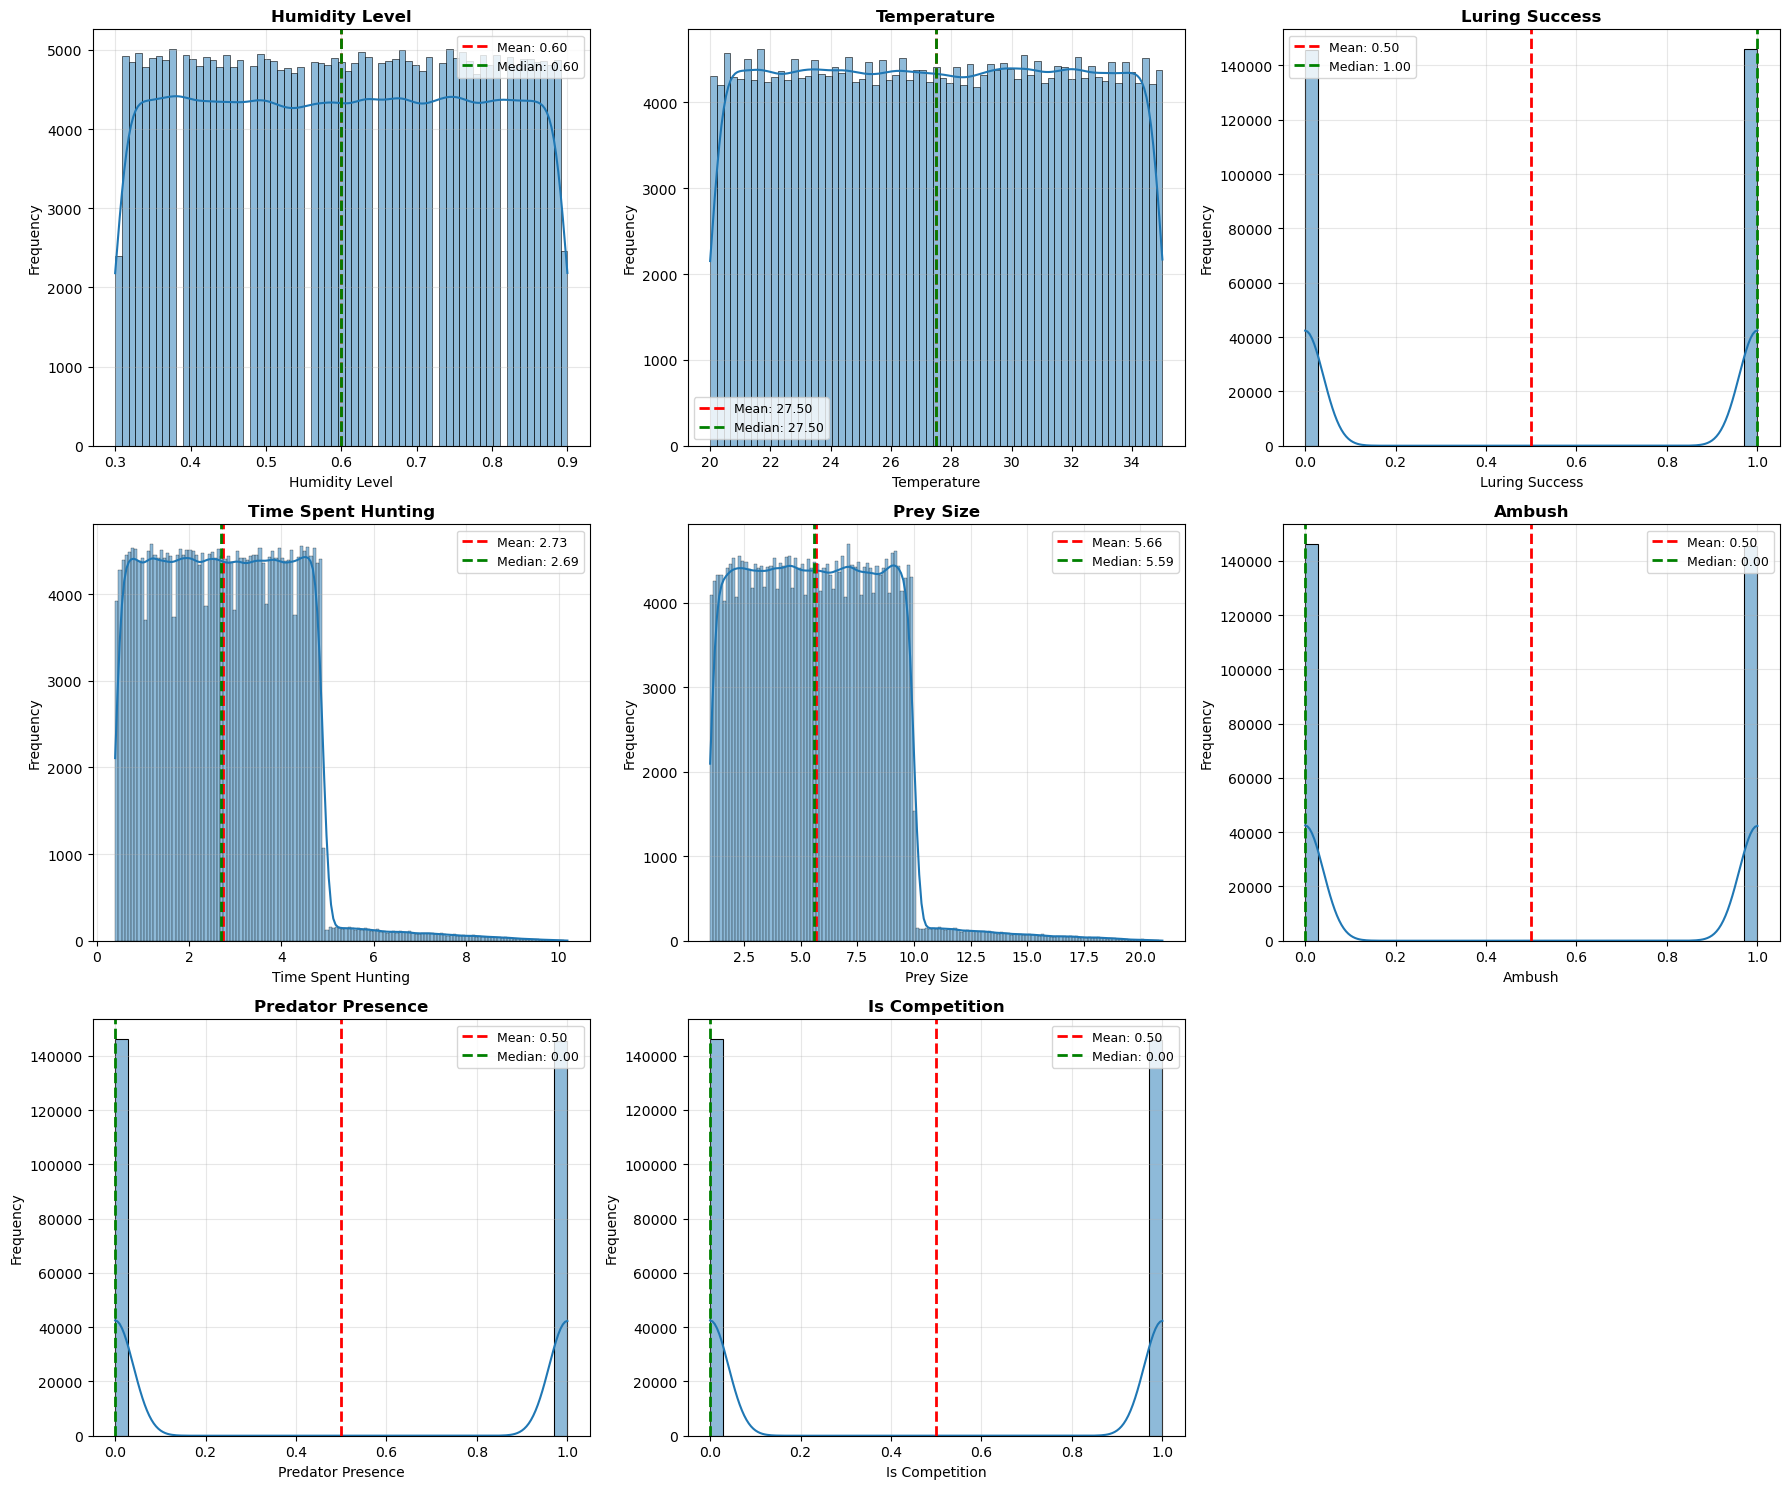

In [15]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<i>Zapažanja: Distribucija kod fičera Time Spent Hunting i Prey Size je pozitivno asimetrična

Boxplots


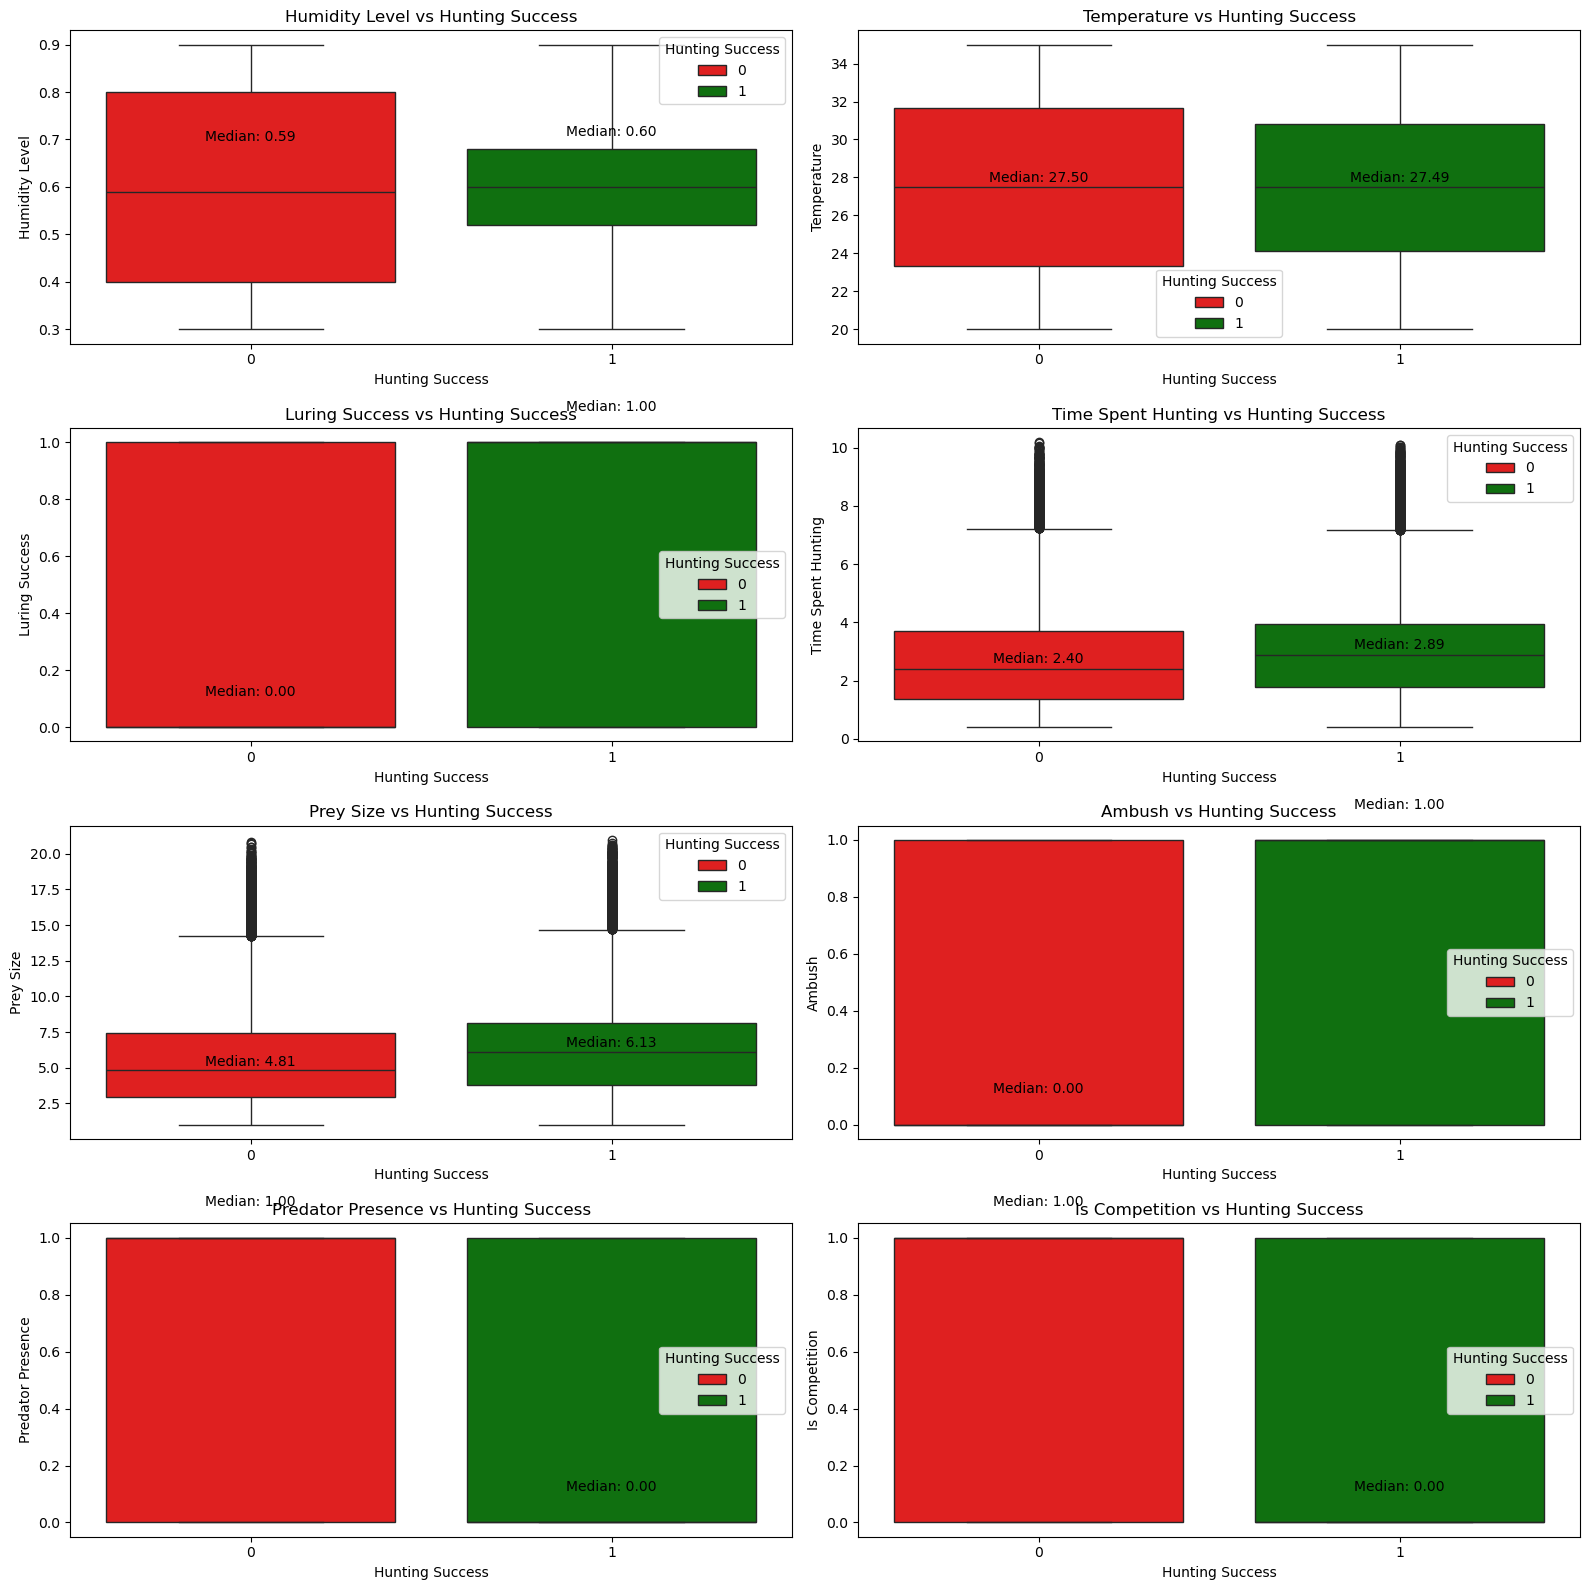

In [16]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
n_cols = 2  
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=ax, palette=('red', 'green'), hue='Hunting Success')
    ax.set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        ax.text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

#### Analiza outlier-a
<i>U prethodnoj analizi, primećeno je na osnovu boxplot-a da se outlier-i nalaze samo u kolonama Time Spent Hunting i Prey Size,a na osnovu histograma sa KDE vidi se da je distribucija podataka asimetrična, pa je zbog toga za detekciju broja outlier-a korišena IQR metoda. </i>

In [17]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')
 
recommendations = []
 
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    outliers_data = dataset[outliers_mask]
    outlier_pct = (len(outliers_data) / len(dataset)) * 100
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = dataset[~outliers_mask]['Hunting Success'].mean()
        impact = abs(outlier_success_rate - normal_success_rate)
    else:
        impact = 0
    recommendations.append({
        'Kolona': col,
        'Broj outlier-a': len(outliers_data),
        'Procenat': f"{outlier_pct:.2f}%",
        'Uticaj na target': f"{impact*100:.2f}%",
    })
 
rec_df = pd.DataFrame(recommendations)
rec_df

,Kolona,Broj outlier-a,Procenat,Uticaj na target
0,Humidity Level,0,0.00%,0.00%
1,Temperature,0,0.00%,0.00%
2,Luring Success,0,0.00%,0.00%
3,Time Spent Hunting,1616,0.55%,3.04%
4,Prey Size,1676,0.57%,7.07%
5,Ambush,0,0.00%,0.00%
6,Predator Presence,0,0.00%,0.00%
7,Is Competition,0,0.00%,0.00%


Analiza uticaja outlier-a na target

Detaljna analiza uticaja outlier-a na target varijablu:



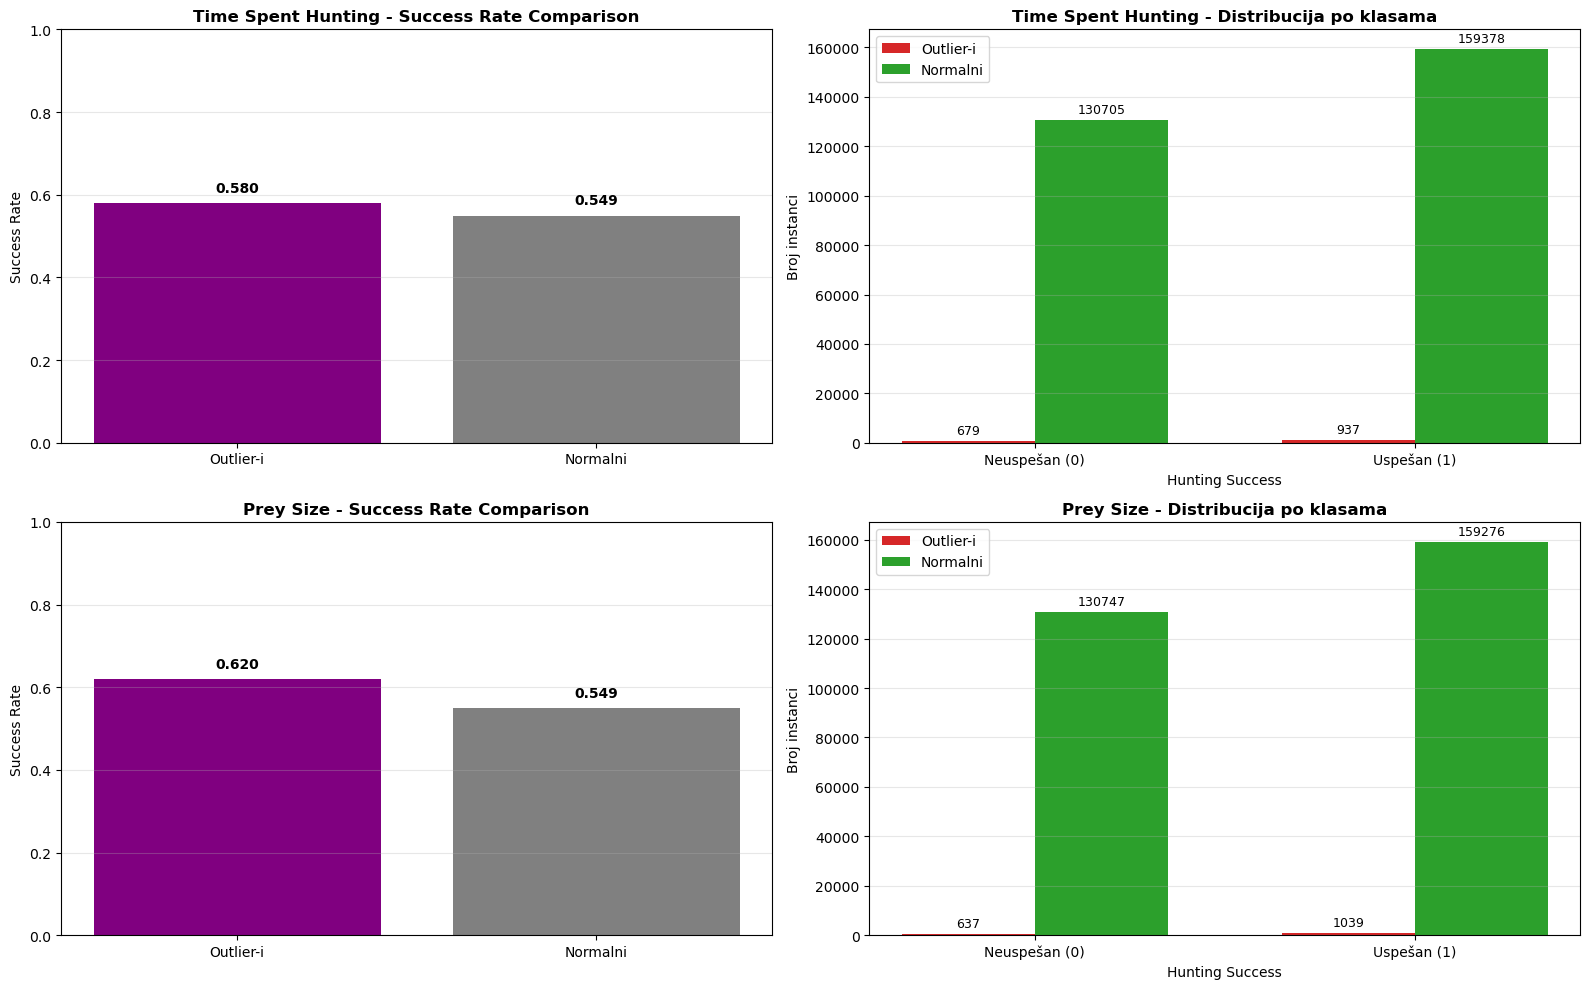

In [18]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

outlier_analysis = []

for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    normal_mask = ~outliers_mask
    
    outliers_data = dataset[outliers_mask]
    normal_data = dataset[normal_mask]
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = normal_data['Hunting Success'].mean()
        
        outlier_dist = outliers_data['Hunting Success'].value_counts()
        outlier_dist_pct = outliers_data['Hunting Success'].value_counts(normalize=True) * 100
        
        normal_dist = normal_data['Hunting Success'].value_counts()
        normal_dist_pct = normal_data['Hunting Success'].value_counts(normalize=True) * 100
        
        impact = abs(outlier_success_rate - normal_success_rate)
        
        outlier_analysis.append({
            'Kolona': col,
            'Broj outlier-a': len(outliers_data),
            'Procenat outlier-a (%)': f"{(len(outliers_data) / len(dataset) * 100):.2f}%",
            'Success rate (outlier-i)': f"{outlier_success_rate:.4f}",
            'Success rate (normalni)': f"{normal_success_rate:.4f}",
            'Razlika u success rate-u': f"{impact:.4f}",
            'Outlier: Hunting Success = 0': f"{outlier_dist.get(0, 0)} ({outlier_dist_pct.get(0, 0):.2f}%)",
            'Outlier: Hunting Success = 1': f"{outlier_dist.get(1, 0)} ({outlier_dist_pct.get(1, 0):.2f}%)",
            'Normalni: Hunting Success = 0': f"{normal_dist.get(0, 0)} ({normal_dist_pct.get(0, 0):.2f}%)",
            'Normalni: Hunting Success = 1': f"{normal_dist.get(1, 0)} ({normal_dist_pct.get(1, 0):.2f}%)"
        })

outlier_analysis_df = pd.DataFrame(outlier_analysis)
print("Detaljna analiza uticaja outlier-a na target varijablu:\n")
outlier_analysis_df

outlier_cols = outlier_analysis_df['Kolona'].tolist()

if len(outlier_cols) > 0:
    fig, axes = plt.subplots(nrows=len(outlier_cols), ncols=2, figsize=(16, 5 * len(outlier_cols)))
    
    if len(outlier_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(outlier_cols):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
        outliers_data = dataset[outliers_mask]
        normal_data = dataset[~outliers_mask]
        
        categories = ['Outlier-i', 'Normalni']
        success_rates = [
            outliers_data['Hunting Success'].mean(),
            normal_data['Hunting Success'].mean()
        ]
        
        axes[i, 0].bar(categories, success_rates, color=["purple", 'grey'], linewidth=1.5)
        axes[i, 0].set_title(f'{col} - Success Rate Comparison', fontsize=12, fontweight='bold')
        axes[i, 0].set_ylabel('Success Rate', fontsize=10)
        axes[i, 0].set_ylim([0, 1])
        axes[i, 0].grid(axis='y', alpha=0.3)
        
        for j, rate in enumerate(success_rates):
            axes[i, 0].text(j, rate + 0.02, f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        outlier_counts = outliers_data['Hunting Success'].value_counts().sort_index()
        normal_counts = normal_data['Hunting Success'].value_counts().sort_index()
        
        x = np.arange(2)
        width = 0.35
        
        outlier_values = [outlier_counts.get(0, 0), outlier_counts.get(1, 0)]
        normal_values = [normal_counts.get(0, 0), normal_counts.get(1, 0)]
        
        axes[i, 1].bar(x - width/2, outlier_values, width, label='Outlier-i', color='#d62728')
        axes[i, 1].bar(x + width/2, normal_values, width, label='Normalni', color='#2ca02c')
        
        axes[i, 1].set_xlabel('Hunting Success', fontsize=10)
        axes[i, 1].set_ylabel('Broj instanci', fontsize=10)
        axes[i, 1].set_title(f'{col} - Distribucija po klasama', fontsize=12, fontweight='bold')
        axes[i, 1].set_xticks(x)
        axes[i, 1].set_xticklabels(['Neuspešan (0)', 'Uspešan (1)'])
        axes[i, 1].legend()
        axes[i, 1].grid(axis='y', alpha=0.3)
        
        for j, (out_val, norm_val) in enumerate(zip(outlier_values, normal_values)):
            if out_val > 0:
                axes[i, 1].text(j - width/2, out_val + max(outlier_values + normal_values) * 0.01, 
                               str(out_val), ha='center', va='bottom', fontsize=9)
            if norm_val > 0:
                axes[i, 1].text(j + width/2, norm_val + max(outlier_values + normal_values) * 0.01, 
                               str(norm_val), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema outlier-a u numeričkim kolonama.")

<i>Zapazanje: Outlier-i imaju veći success rate -> veći plen i duže vreme provedeno u lovu = veća uspešnost u lovu
Pretpostavka:  Ekstremne vrednosti su povezane sa većim uspehom, nisu greške u podacima i predstavjaju retke ali važne slučajeve
Odluka: Ne uklanjati outlier-e.

Korelaciona matrica

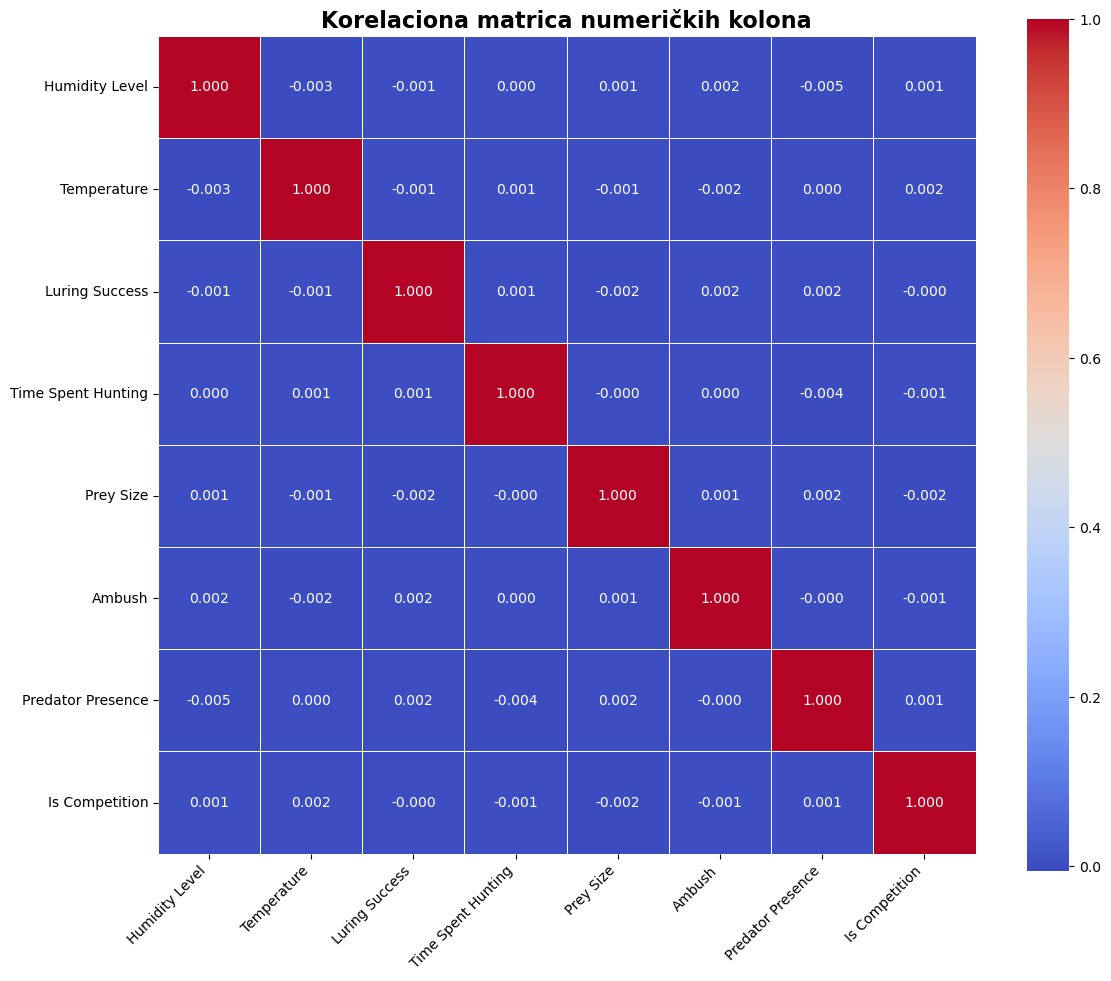

In [19]:
corr_matrix = dataset[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, square=True)
plt.title('Korelaciona matrica numeričkih kolona', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Korelacija feature sa target kolonom

In [20]:
from scipy.stats import pointbiserialr

for col in dataset.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(dataset["Hunting Success"], dataset[col])
    print(f"{col}: {corr:.4f}")

Humidity Level: 0.0013
Temperature: -0.0002
Luring Success: 0.1110
Time Spent Hunting: 0.1098
Prey Size: 0.1366
Ambush: 0.1880
Predator Presence: -0.0709
Is Competition: -0.0727
Hunting Success: 1.0000


Analiza kategorijskih kolona

In [21]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


Value counts za kategorijske kolone


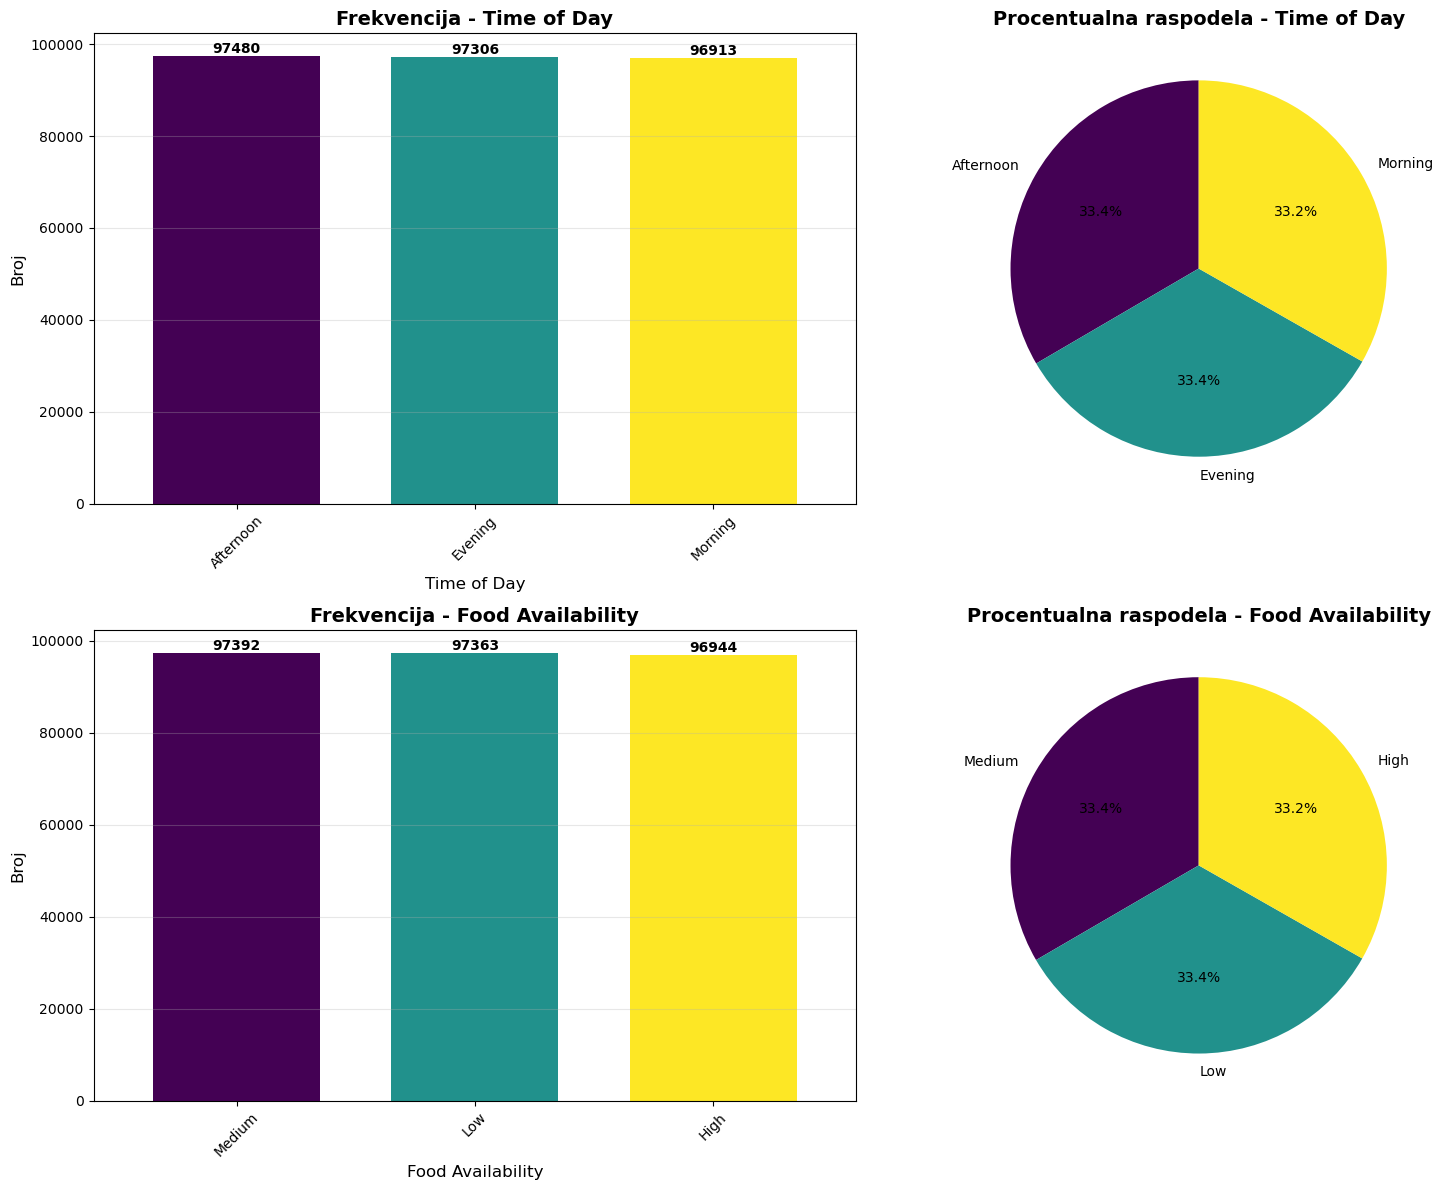

In [22]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = dataset[col].value_counts()
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


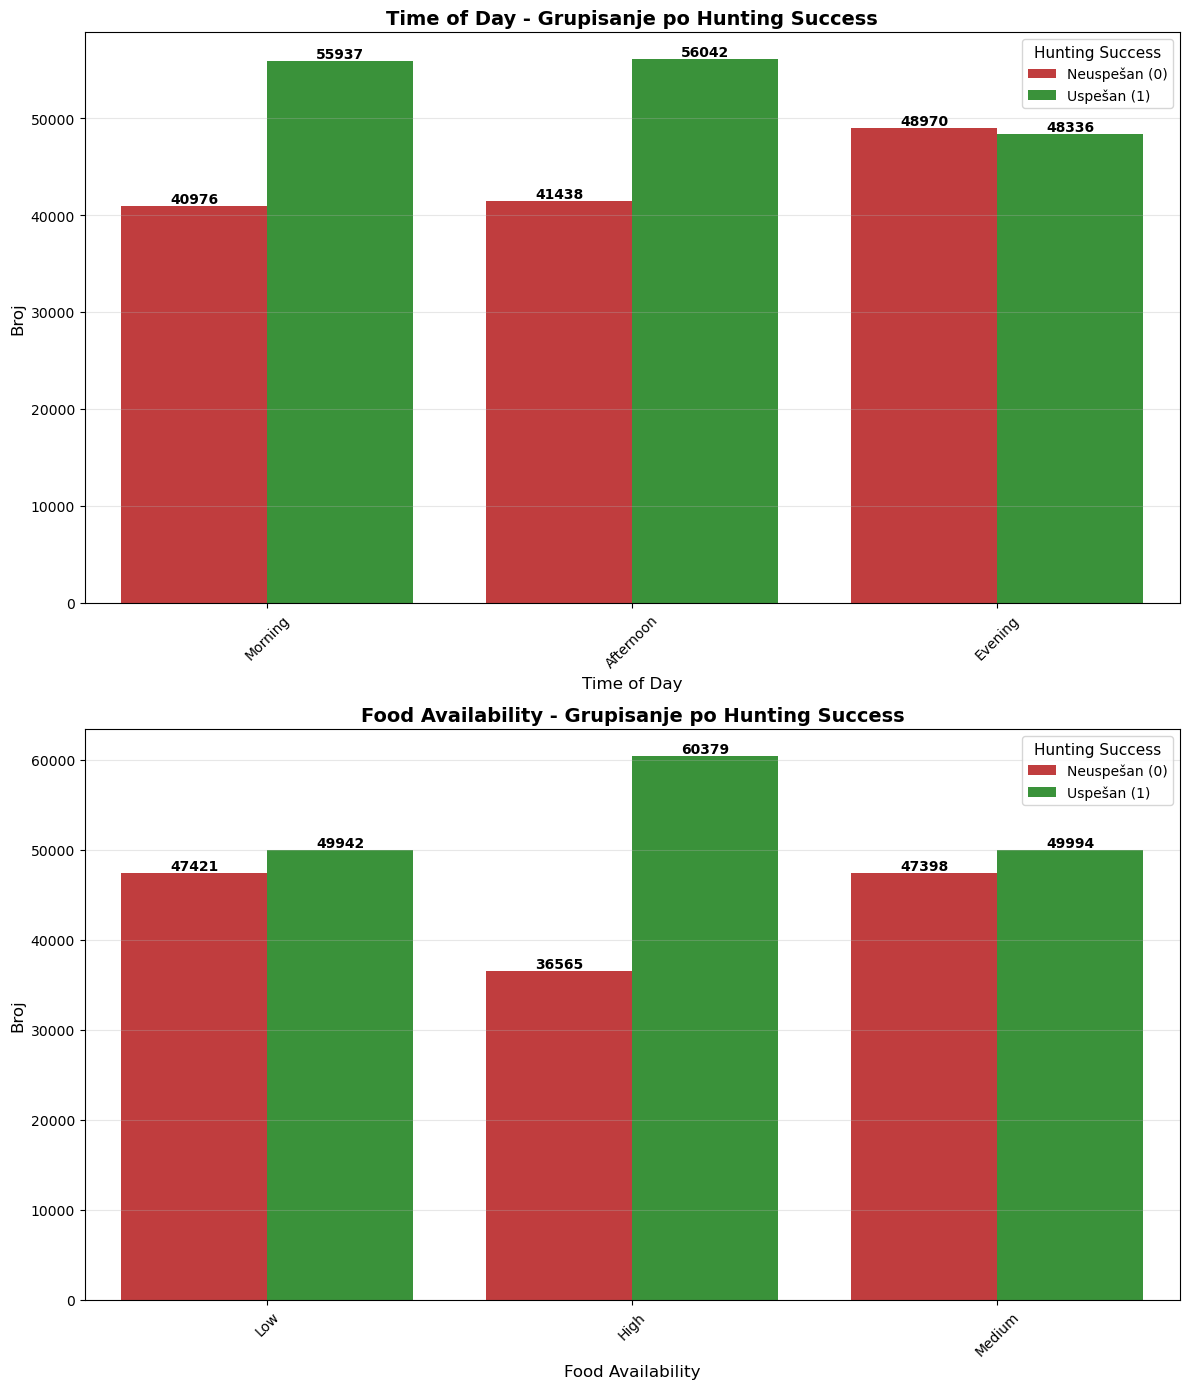

In [23]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


Kolone Time of Day and Food Availability su kategorijske i na njih može da se primeni one-hot encoding

In [24]:
time_of_day_one_hot = pd.get_dummies(dataset['Time of Day'], prefix='Time of Day', dummy_na=False)
food_availability_one_hot = pd.get_dummies(dataset['Food Availability'], prefix='Food Availability', dummy_na=False)

dataset = dataset.drop(columns=['Time of Day', 'Food Availability'])

dataset = pd.concat([dataset, time_of_day_one_hot, food_availability_one_hot], axis=1)

ostale_kolone = [col for col in dataset.columns if col not in list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns)]
hunting_success_index = ostale_kolone.index('Hunting Success')

nove_kolone = ostale_kolone[:hunting_success_index] + list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns) + ['Hunting Success'] + ostale_kolone[hunting_success_index + 1:]

dataset = dataset[nove_kolone]

dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Humidity Level            291699 non-null  float64
 1   Temperature               291699 non-null  float64
 2   Luring Success            291699 non-null  int64  
 3   Time Spent Hunting        291699 non-null  float64
 4   Prey Size                 291699 non-null  float64
 5   Ambush                    291699 non-null  int64  
 6   Predator Presence         291699 non-null  int64  
 7   Is Competition            291699 non-null  int64  
 8   Time of Day_Afternoon     291699 non-null  int64  
 9   Time of Day_Evening       291699 non-null  int64  
 10  Time of Day_Morning       291699 non-null  int64  
 11  Food Availability_High    291699 non-null  int64  
 12  Food Availability_Low     291699 non-null  int64  
 13  Food Availability_Medium  291699 non-null  int64 

## <b>4. Baseline modeli </b>


Podela dataseta na test i train setove

In [25]:
y = dataset['Hunting Success']
X = dataset.drop(columns=['Hunting Success'])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

(291699, 14)
(291699,)
X_train shape: (233359, 14)
X_test shape: (58340, 14)


<i>Pomoćne metode za prikaz rezultata</i>

In [26]:
def confusion_matrix_result(y_test, y_pred_test, model_name): 
    cm = confusion_matrix(y_test, y_pred_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

In [27]:
metrics = ["Accuracy", "Precision_0","Precision_1", "Recall_0", "Recall_1", "F1-Score_0", "F1-Score_1", "F1-Score_Weighted"]

result_df = pd.DataFrame(index=metrics)

In [28]:
def report_result(y_test, y_pred, model_name):

    accuracy_test = accuracy_score(y_test, y_pred)
    f1_score_test = f1_score(y_test, y_pred, average="weighted")

    print(f'Accuracy: {accuracy_test * 100:.2f}%')
    print(f'F1 Score: {f1_score_test * 100:.2f}%')

    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report_dict).transpose()

    for col in ['precision', 'recall', 'f1-score']:
        report[col] = report[col].apply(lambda x: round(x * 100, 2))

    result_df[model_name] = [
        round(accuracy_test * 100,2),
        round(report_dict['0']['precision'] * 100, 2),
        round(report_dict['1']['precision'] * 100, 2),
        round(report_dict['0']['recall'] * 100, 2),
        round(report_dict['1']['recall'] * 100, 2),
        round(report_dict['0']['f1-score'] * 100, 2),
        round(report_dict['1']['f1-score'] * 100, 2),
        round(f1_score_test * 100, 2) 
    ]
    return report

Lazy predict

In [29]:
from lazypredict.Supervised import CLASSIFIERS
 
skip = [
    "SVC",
    "NuSVC"
]
 
fast_classifiers = [cls for name, cls in CLASSIFIERS if name not in skip]
print(fast_classifiers)
 
clf = LazyClassifier( verbose=0, ignore_warnings=True, classifiers=fast_classifiers )
 
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
 
print(models)

[<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, <class 'sklearn.ensemble._bagging.BaggingClassifier'>, <class 'sklearn.naive_bayes.BernoulliNB'>, <class 'sklearn.calibration.CalibratedClassifierCV'>, <class 'sklearn.naive_bayes.CategoricalNB'>, <class 'sklearn.tree._classes.DecisionTreeClassifier'>, <class 'sklearn.dummy.DummyClassifier'>, <class 'sklearn.tree._classes.ExtraTreeClassifier'>, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, <class 'sklearn.model_selection._classification_threshold.FixedThresholdClassifier'>, <class 'sklearn.naive_bayes.GaussianNB'>, <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>, <class 'sklearn.semi_supervised._label_propagation.LabelSpreading'>, <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, <class 'sklearn.svm._classes.LinearSVC'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.neighbors.

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 128252, number of negative: 105107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 233359, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549591 -> initscore=0.199018
[LightGBM] [Info] Start training from score 0.199018
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.97               0.97     0.97      0.97   
RandomForestClassifier             0.97               0.97     0.97      0.97   
LGBMClassifier                     0.97               0.97     0.97      0.97   
BaggingClassifier                  0.

<i>Izabrani su modeli sa >0.9 preciznošću: Random Forest Classifier, LGM Classifier, XGB Classifier, Bagging Classifier, Extra Trees Classifier i Decision Tree Classifier</i>

### <b> 4.1. Random Forest Classifier - Baseline Model</b>

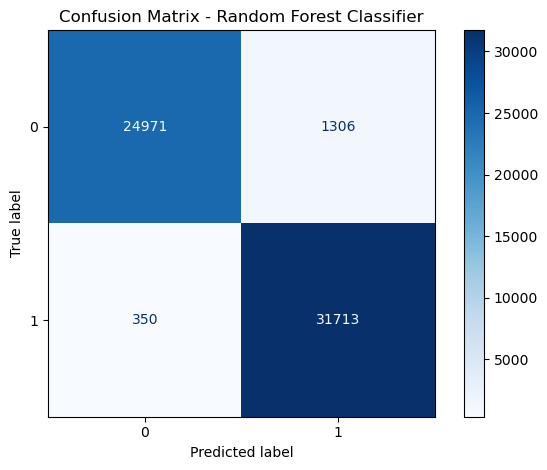

Accuracy: 97.16%
F1 Score: 97.16%


,precision,recall,f1-score,support
0,98.62,95.03,96.79,26277.00
1,96.04,98.91,97.46,32063.00
accuracy,97.16,97.16,97.16,0.97
macro avg,97.33,96.97,97.12,58340.00
weighted avg,97.20,97.16,97.16,58340.00


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
 
rf_baseline = RandomForestClassifier()
 
rf_baseline.fit(X_train, y_train)

y_pred_rf = rf_baseline.predict(X_test)
 
confusion_matrix_result(y_test, y_pred_rf, 'Random Forest Classifier')
report_result(y_test, y_pred_rf, "Random Forest - Baseline")

### <b>4.2. LGBM Classifier - Baseline Model</b>

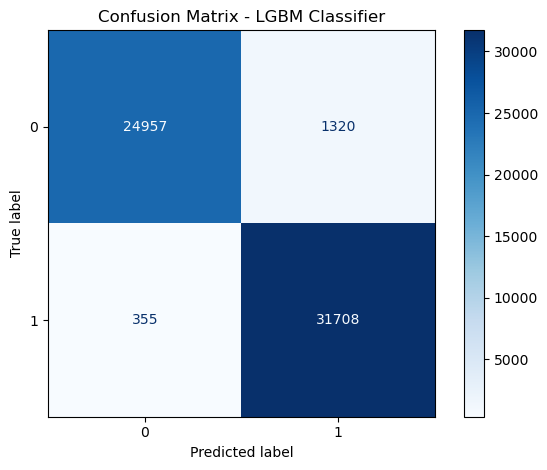

Accuracy: 97.13%
F1 Score: 97.12%


,precision,recall,f1-score,support
0,98.60,94.98,96.75,26277.00
1,96.00,98.89,97.43,32063.00
accuracy,97.13,97.13,97.13,0.97
macro avg,97.30,96.93,97.09,58340.00
weighted avg,97.17,97.13,97.12,58340.00


In [31]:
lgbm_baseline = LGBMClassifier(
    random_state=42,
    verbose= -1
)

lgbm_baseline.fit(X_train, y_train)
y_pred_lgbm = lgbm_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_lgbm, 'LGBM Classifier')
report_result(y_test, y_pred_lgbm, "LGBM - Baseline")

### <b>4.3. XGB Classifier - Baseline model</b>

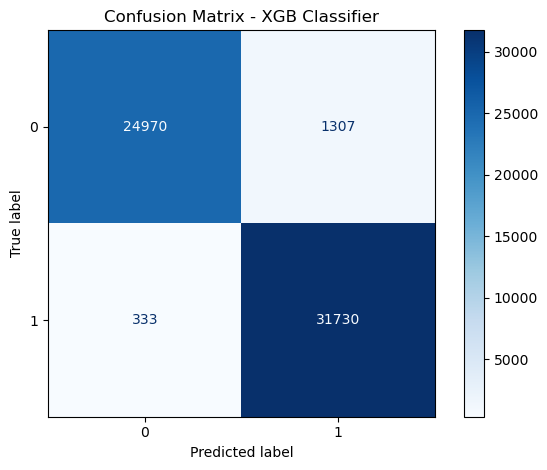

Accuracy: 97.19%
F1 Score: 97.18%


,precision,recall,f1-score,support
0,98.68,95.03,96.82,26277.00
1,96.04,98.96,97.48,32063.00
accuracy,97.19,97.19,97.19,0.97
macro avg,97.36,96.99,97.15,58340.00
weighted avg,97.23,97.19,97.18,58340.00


In [32]:
xgb_baseline = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_baseline.fit(X_train, y_train)
y_pred_xgb = xgb_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_xgb, 'XGB Classifier')
report_result(y_test, y_pred_xgb, "XGB - Baseline")

### <b>4.4. Bagging Classifier - Baseline model</b>

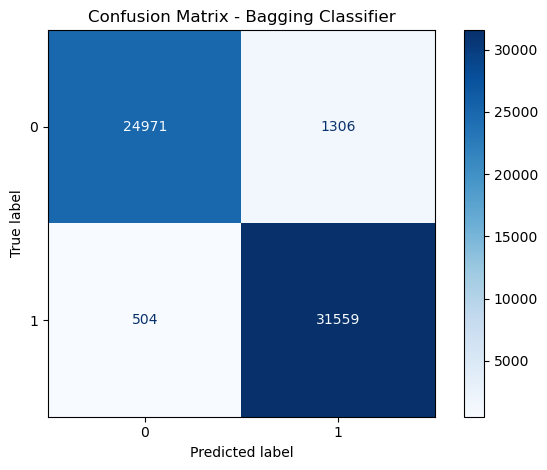

Accuracy: 96.90%
F1 Score: 96.89%


,precision,recall,f1-score,support
0,98.02,95.03,96.50,26277.00
1,96.03,98.43,97.21,32063.00
accuracy,96.90,96.90,96.90,0.97
macro avg,97.02,96.73,96.86,58340.00
weighted avg,96.92,96.90,96.89,58340.00


In [33]:
bagging_clf = BaggingClassifier(random_state=42)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)

confusion_matrix_result(y_test, y_pred_bagging, 'Bagging Classifier')
report_result(y_test, y_pred_bagging, "Bagging - Baseline")

### <b>4.5. Extra Trees Classifier - Baseline model</b>

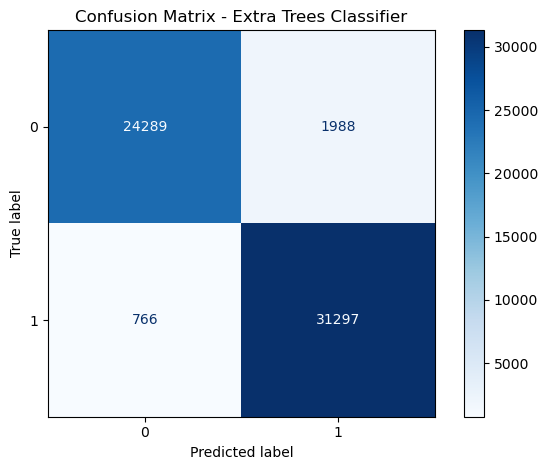

Accuracy: 95.28%
F1 Score: 95.27%


,precision,recall,f1-score,support
0,96.94,92.43,94.63,26277.00
1,94.03,97.61,95.79,32063.00
accuracy,95.28,95.28,95.28,0.95
macro avg,95.49,95.02,95.21,58340.00
weighted avg,95.34,95.28,95.27,58340.00


In [34]:
etc_baseline = ExtraTreesClassifier(random_state=42)
etc_baseline.fit(X_train, y_train)
y_pred_etc = etc_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_etc, 'Extra Trees Classifier')
report_result(y_test, y_pred_etc, "Extra Trees - Baseline")

### <b>4.6. Decision Tree Classifier - Baseline model</b>

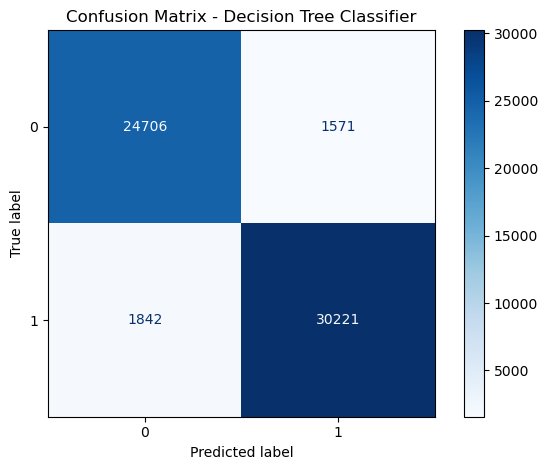

Accuracy: 94.15%
F1 Score: 94.15%


,precision,recall,f1-score,support
0,93.06,94.02,93.54,26277.00
1,95.06,94.26,94.66,32063.00
accuracy,94.15,94.15,94.15,0.94
macro avg,94.06,94.14,94.10,58340.00
weighted avg,94.16,94.15,94.15,58340.00


In [35]:

dtc_baseline = DecisionTreeClassifier(random_state=42)
dtc_baseline.fit(X_train, y_train)
y_pred_dtc = dtc_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_dtc, 'Decision Tree Classifier')
report_result(y_test, y_pred_dtc, "Decision Tree - Baseline")

<i> Zapažanje: Svi modeli (osim Decision Tree, koji se najgore pokazao u predikciji) su blago naklonuti ka klasi 1 (Uspešan lov).

## <b> 5. Optimizovanje hiperparametara izabranih algoritama </b>

### <b>5.1 Random Forest Classifier</b> 

In [36]:

param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42
)

rf_base = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1
)

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)

best_params_rf = rf_random_search.best_params_

best_params_rf["CV F1 Score (%)"] = round(rf_random_search.best_score_ * 100, 2)

best_rf_df = pd.DataFrame([best_params_rf])
for col in best_rf_df.columns:
    if best_rf_df[col].dtype == float and best_rf_df[col].max() < 1:
        best_rf_df[col] = best_rf_df[col].round(3)

best_rf_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,CV F1 Score (%)
0,300,5,1,log2,10,None,97.60


In [37]:
best_rf = rf_random_search.best_estimator_
y_rf_pred_test = best_rf.predict(X_test)

report_result(y_test, y_rf_pred_test, "Random Forest - Optimized")

Accuracy: 97.19%
F1 Score: 97.18%


,precision,recall,f1-score,support
0,98.68,95.03,96.82,26277.00
1,96.04,98.96,97.48,32063.00
accuracy,97.19,97.19,97.19,0.97
macro avg,97.36,96.99,97.15,58340.00
weighted avg,97.23,97.19,97.18,58340.00


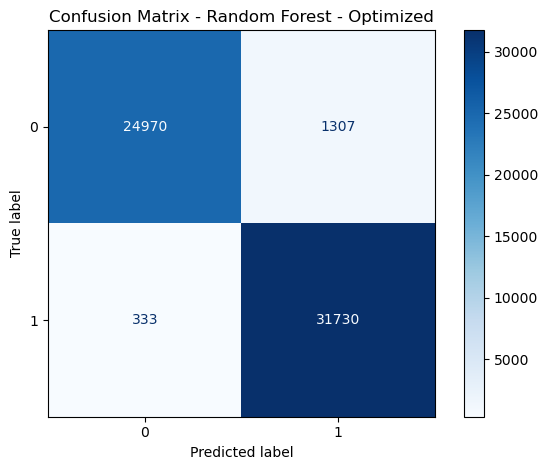

In [38]:
confusion_matrix_result(y_test, y_rf_pred_test, 'Random Forest - Optimized')

### <b> 5.2 LGBM Classifier </b>
 

In [39]:
from lightgbm import LGBMClassifier

lgbm_param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [10, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.5, 1.0]
}

lgbm_base = LGBMClassifier(
    random_state=42,
    objective='binary',
    n_jobs=-1,
    verbose=-1
)

cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42
)

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose= 0
)

lgbm_random_search.fit(X_train, y_train)

best_params = lgbm_random_search.best_params_

best_params["CV F1 Score (%)"] = round(lgbm_random_search.best_score_ * 100, 2)

best_lgbm_df = pd.DataFrame([best_params])

for col in best_lgbm_df.columns:
    if best_lgbm_df[col].dtype == float and best_lgbm_df[col].max() < 1:
        best_lgbm_df[col] = best_lgbm_df[col].round(3)

best_lgbm_df

,subsample,reg_lambda,reg_alpha,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,colsample_bytree,CV F1 Score (%)
0,0.80,1.00,0.10,31,400,20,-1,0.10,1.00,97.53


In [40]:
best_lgbm = lgbm_random_search.best_estimator_
y_lgbm_pred_test = best_lgbm.predict(X_test)

report_result(y_test, y_lgbm_pred_test, "LGBM - Optimized")

Accuracy: 97.12%
F1 Score: 97.11%


,precision,recall,f1-score,support
0,98.59,94.96,96.74,26277.00
1,95.99,98.89,97.42,32063.00
accuracy,97.12,97.12,97.12,0.97
macro avg,97.29,96.93,97.08,58340.00
weighted avg,97.16,97.12,97.11,58340.00


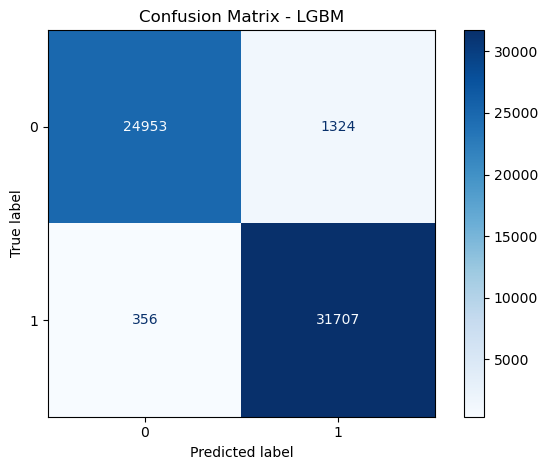

In [41]:
cm = confusion_matrix(y_test, y_lgbm_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LGBM')
plt.tight_layout()
plt.show()

### <b> 5.3 XGB Classifier </b>

In [42]:
xgb_base = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_random_search.fit(X_train, y_train)

best_params_xgb = xgb_random_search.best_params_

best_params_xgb["CV F1 Score (%)"] = round(xgb_random_search.best_score_ * 100, 2)

best_xgb_df = pd.DataFrame([best_params_xgb])
for col in best_xgb_df.columns:
    if best_xgb_df[col].dtype == float and best_xgb_df[col].max() < 1:
        best_xgb_df[col] = best_xgb_df[col].round(3)

best_xgb_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,CV F1 Score (%)
0,0.70,1,0,500,3,3,0.05,0.50,1.00,97.60


In [43]:
best_xgb = xgb_random_search.best_estimator_
y_xgb_pred_test = best_xgb.predict(X_test)

report_result(y_test, y_xgb_pred_test, "XGB - Optimized")

Accuracy: 97.19%
F1 Score: 97.18%


,precision,recall,f1-score,support
0,98.68,95.03,96.82,26277.00
1,96.04,98.96,97.48,32063.00
accuracy,97.19,97.19,97.19,0.97
macro avg,97.36,96.99,97.15,58340.00
weighted avg,97.23,97.19,97.18,58340.00


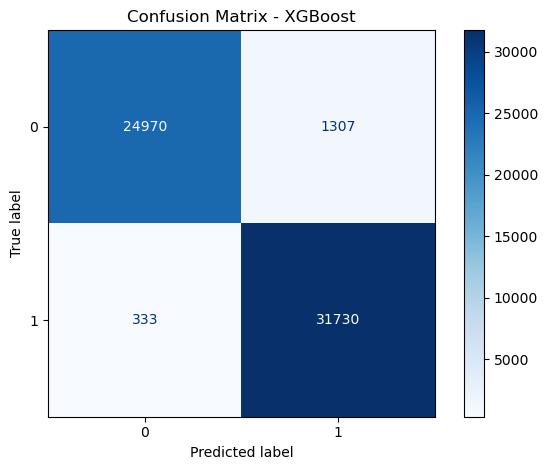

In [44]:
cm_xgb = confusion_matrix(y_test, y_xgb_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### <b> 5.4 Bagging Classifier </b>

In [45]:
bagging_base = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

bagging_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
bagging_random_search = RandomizedSearchCV(
    estimator=bagging_base,
    param_distributions=bagging_param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
bagging_random_search.fit(X_train, y_train)

best_params_bagging = bagging_random_search.best_params_

best_params_bagging["CV F1 Score (%)"] = round(bagging_random_search.best_score_ * 100, 2)

best_bagging_df = pd.DataFrame([best_params_bagging])
for col in best_bagging_df.columns:
    if best_bagging_df[col].dtype == float and best_bagging_df[col].max() < 1:
        best_bagging_df[col] = best_bagging_df[col].round(3)

best_bagging_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,n_estimators,max_samples,max_features,bootstrap_features,bootstrap,CV F1 Score (%)
0,200,0.70,1.00,False,True,97.55


In [46]:
best_bagging = bagging_random_search.best_estimator_
y_bagging_pred_test = best_bagging.predict(X_test)

report_result(y_test, y_bagging_pred_test, "Bagging - Optimized")

Accuracy: 97.15%
F1 Score: 97.15%


,precision,recall,f1-score,support
0,98.59,95.04,96.78,26277.00
1,96.05,98.89,97.45,32063.00
accuracy,97.15,97.15,97.15,0.97
macro avg,97.32,96.96,97.12,58340.00
weighted avg,97.20,97.15,97.15,58340.00


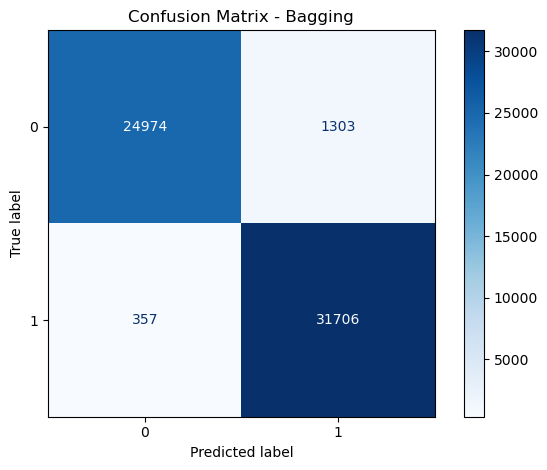

In [47]:
cm_bagging = confusion_matrix(y_test, y_bagging_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagging)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Bagging')
plt.tight_layout()
plt.show()

### <b> 5.5 Extra Trees Classifier </b>

In [48]:
etc_base = ExtraTreesClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
etc_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

etc_random_search = RandomizedSearchCV(
    estimator=etc_base,
    param_distributions=etc_param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
etc_random_search.fit(X_train, y_train)

best_params_etc = etc_random_search.best_params_

best_params_etc["CV F1 Score (%)"] = round(etc_random_search.best_score_ * 100, 2)

best_etc_df = pd.DataFrame([best_params_etc])
for col in best_etc_df.columns:
    if best_etc_df[col].dtype == float and best_etc_df[col].max() < 1:
        best_etc_df[col] = best_etc_df[col].round(3)

best_etc_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,bootstrap,CV F1 Score (%)
0,300,10,4,None,None,balanced,False,97.53


In [49]:
best_etc = etc_random_search.best_estimator_
y_etc_pred_test = best_etc.predict(X_test)

report_result(y_test, y_etc_pred_test, "Extra Trees - Optimized")

Accuracy: 97.15%
F1 Score: 97.15%


,precision,recall,f1-score,support
0,98.62,95.01,96.78,26277.00
1,96.03,98.91,97.45,32063.00
accuracy,97.15,97.15,97.15,0.97
macro avg,97.32,96.96,97.11,58340.00
weighted avg,97.20,97.15,97.15,58340.00


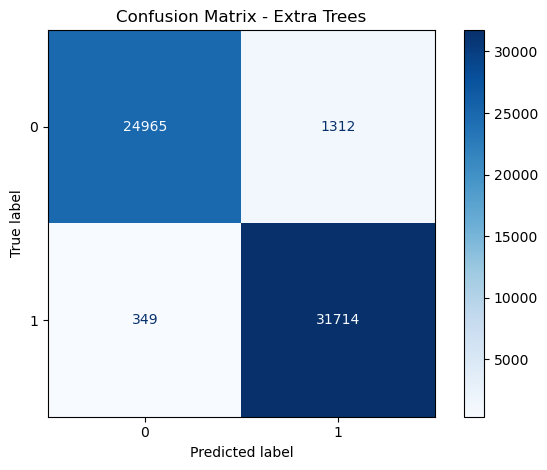

In [50]:
cm_etc = confusion_matrix(y_test, y_etc_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_etc)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Extra Trees')
plt.tight_layout()
plt.show()

###  <b> 5.6 Decision Trees Classifier </b>

In [51]:
dt_base = DecisionTreeClassifier(
    random_state=42
)

dt_param_dist = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

dt_random_search = RandomizedSearchCV(
    estimator=dt_base,
    param_distributions=dt_param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
dt_random_search.fit(X_train, y_train)

best_params_dt = dt_random_search.best_params_

best_params_dt["CV F1 Score (%)"] = round(dt_random_search.best_score_ * 100, 2)

best_dt_df = pd.DataFrame([best_params_dt])
for col in best_dt_df.columns:
    if best_dt_df[col].dtype == float and best_dt_df[col].max() < 1:
        best_dt_df[col] = best_dt_df[col].round(3)

best_dt_df

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,class_weight,CV F1 Score (%)
0,5,1,None,10,gini,None,97.39


In [52]:
best_dt = dt_random_search.best_estimator_
y_dt_pred_test = best_dt.predict(X_test)

report_result(y_test, y_dt_pred_test, "Decision Tree - Optimized")

Accuracy: 96.97%
F1 Score: 96.96%


,precision,recall,f1-score,support
0,98.33,94.88,96.58,26277.00
1,95.92,98.68,97.28,32063.00
accuracy,96.97,96.97,96.97,0.97
macro avg,97.13,96.78,96.93,58340.00
weighted avg,97.01,96.97,96.96,58340.00


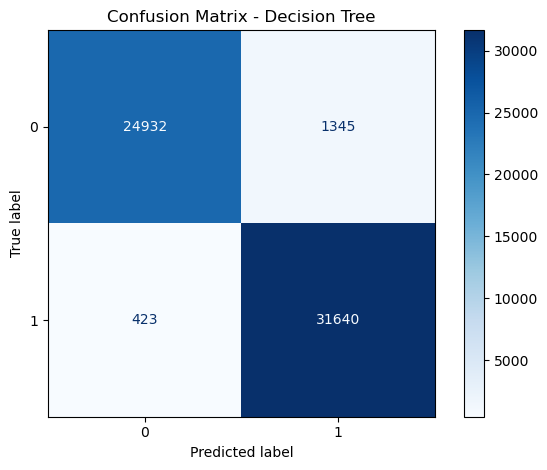

In [53]:
cm_dt = confusion_matrix(y_test, y_dt_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

### <b> Poređenje rezultata modela </b>
 
<i>U ovoj ćeliji se prikazuju svi rezultati baseline i optimizovanih modela za lakše poređenje.</i>

In [54]:
column_order = [
    "Random Forest - Baseline", "Random Forest - Optimized",
    "LGBM - Baseline", "LGBM - Optimized",
    "XGB - Baseline", "XGB - Optimized",
    "Bagging - Baseline", "Bagging - Optimized",
    "Extra Trees - Baseline", "Extra Trees - Optimized",
    "Decision Tree - Baseline", "Decision Tree - Optimized"
]

existing_columns = [col for col in column_order if col in result_df.columns]
result_df[existing_columns]

,Random Forest - Baseline,Random Forest - Optimized,LGBM - Baseline,LGBM - Optimized,XGB - Baseline,XGB - Optimized,Bagging - Baseline,Bagging - Optimized,Extra Trees - Baseline,Extra Trees - Optimized,Decision Tree - Baseline,Decision Tree - Optimized
Accuracy,97.16,97.19,97.13,97.12,97.19,97.19,96.90,97.15,95.28,97.15,94.15,96.97
Precision_0,98.62,98.68,98.60,98.59,98.68,98.68,98.02,98.59,96.94,98.62,93.06,98.33
Precision_1,96.04,96.04,96.00,95.99,96.04,96.04,96.03,96.05,94.03,96.03,95.06,95.92
Recall_0,95.03,95.03,94.98,94.96,95.03,95.03,95.03,95.04,92.43,95.01,94.02,94.88
Recall_1,98.91,98.96,98.89,98.89,98.96,98.96,98.43,98.89,97.61,98.91,94.26,98.68
F1-Score_0,96.79,96.82,96.75,96.74,96.82,96.82,96.50,96.78,94.63,96.78,93.54,96.58
F1-Score_1,97.46,97.48,97.43,97.42,97.48,97.48,97.21,97.45,95.79,97.45,94.66,97.28
F1-Score_Weighted,97.16,97.18,97.12,97.11,97.18,97.18,96.89,97.15,95.27,97.15,94.15,96.96


In [55]:
f1_score_df_rang = result_df.loc["F1-Score_Weighted"]

f1_score_df_rang = f1_score_df_rang.to_frame(name="F1-Score_Weighted")

f1_sorted = f1_score_df_rang.sort_values(by="F1-Score_Weighted", ascending=False)

print(f1_sorted)

                           F1-Score_Weighted
XGB - Baseline                         97.18
Random Forest - Optimized              97.18
XGB - Optimized                        97.18
Random Forest - Baseline               97.16
Bagging - Optimized                    97.15
Extra Trees - Optimized                97.15
LGBM - Baseline                        97.12
LGBM - Optimized                       97.11
Decision Tree - Optimized              96.96
Bagging - Baseline                     96.89
Extra Trees - Baseline                 95.27
Decision Tree - Baseline               94.15


In [56]:
accuracy_df_rang = result_df.loc["Accuracy"]

accuracy_df_rang = accuracy_df_rang.to_frame(name="Accuracy")

accuracy_sorted = accuracy_df_rang.sort_values(by="Accuracy", ascending=False)

print(accuracy_sorted)

                           Accuracy
XGB - Baseline                97.19
Random Forest - Optimized     97.19
XGB - Optimized               97.19
Random Forest - Baseline      97.16
Bagging - Optimized           97.15
Extra Trees - Optimized       97.15
LGBM - Baseline               97.13
LGBM - Optimized              97.12
Decision Tree - Optimized     96.97
Bagging - Baseline            96.90
Extra Trees - Baseline        95.28
Decision Tree - Baseline      94.15


In [57]:
models_for_lime = {
    'LGBM': best_lgbm,
    'Random Forest': best_rf,
    'XGB': best_xgb,
    'Extra Trees': best_etc,
    'Decision Tree': best_dt
}
 
print("Svi modeli su sačuvani u 'models_for_lime' dictionary!")
print(f"Dostupni modeli: {list(models_for_lime.keys())}")

Svi modeli su sačuvani u 'models_for_lime' dictionary!
Dostupni modeli: ['LGBM', 'Random Forest', 'XGB', 'Extra Trees', 'Decision Tree']


## <b> 6. Detaljna analiza interpretabilnosti dobijenih modela</b>

### <b> 6.1. Feature Importance </b>

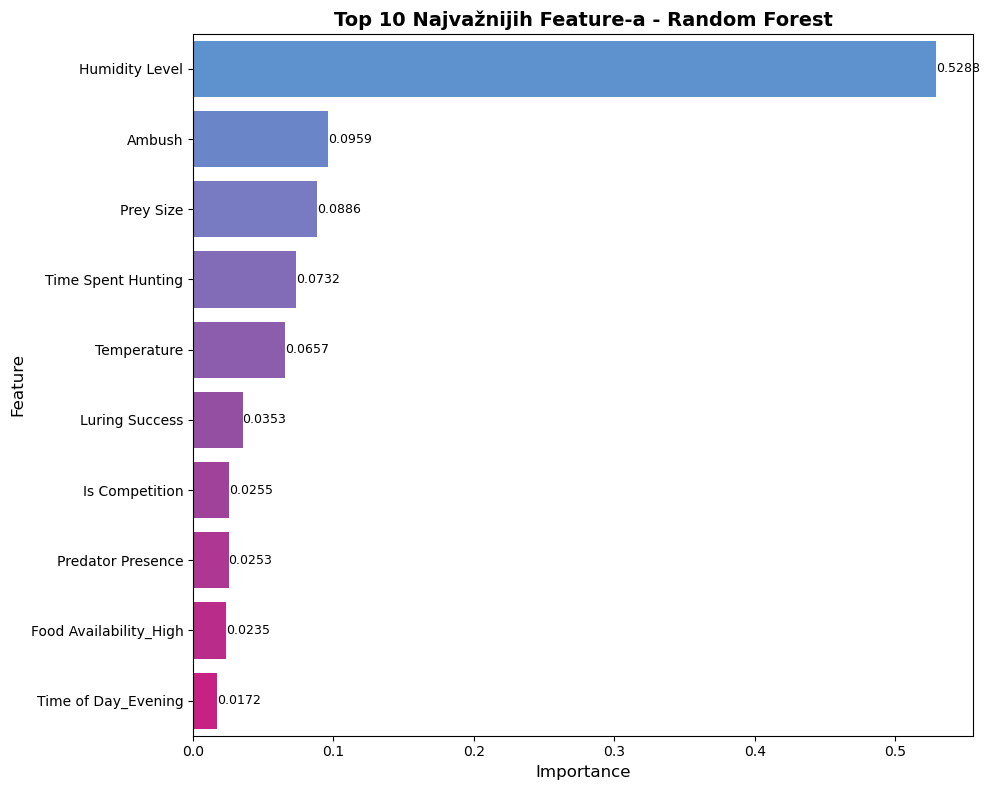

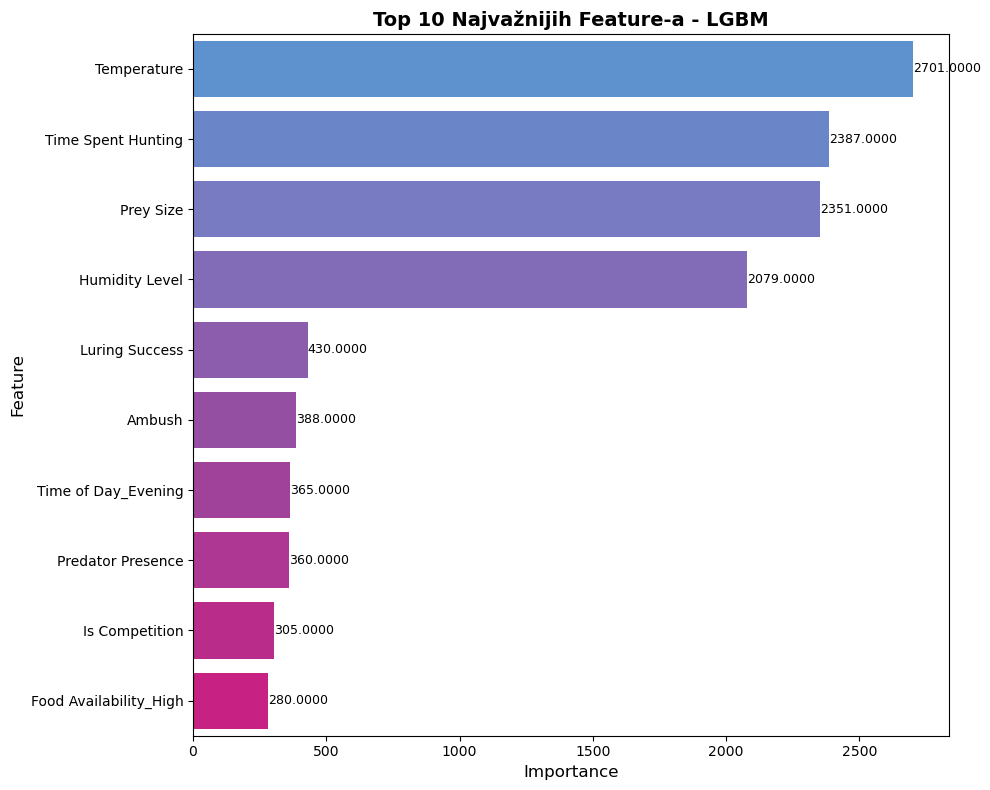

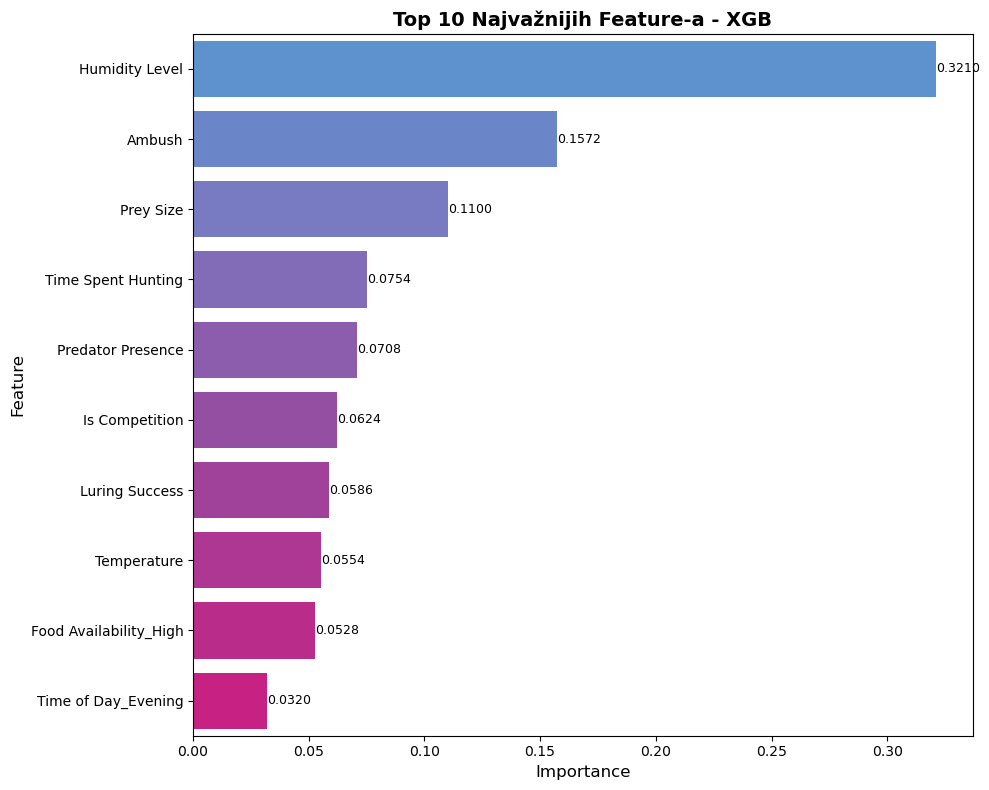

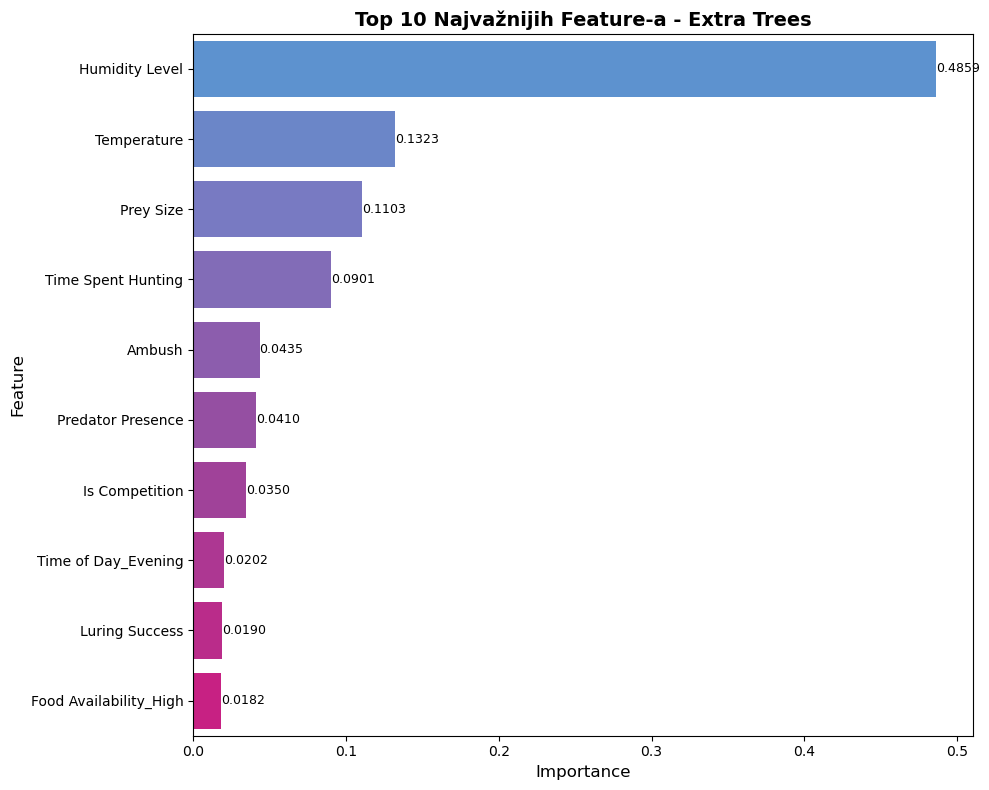

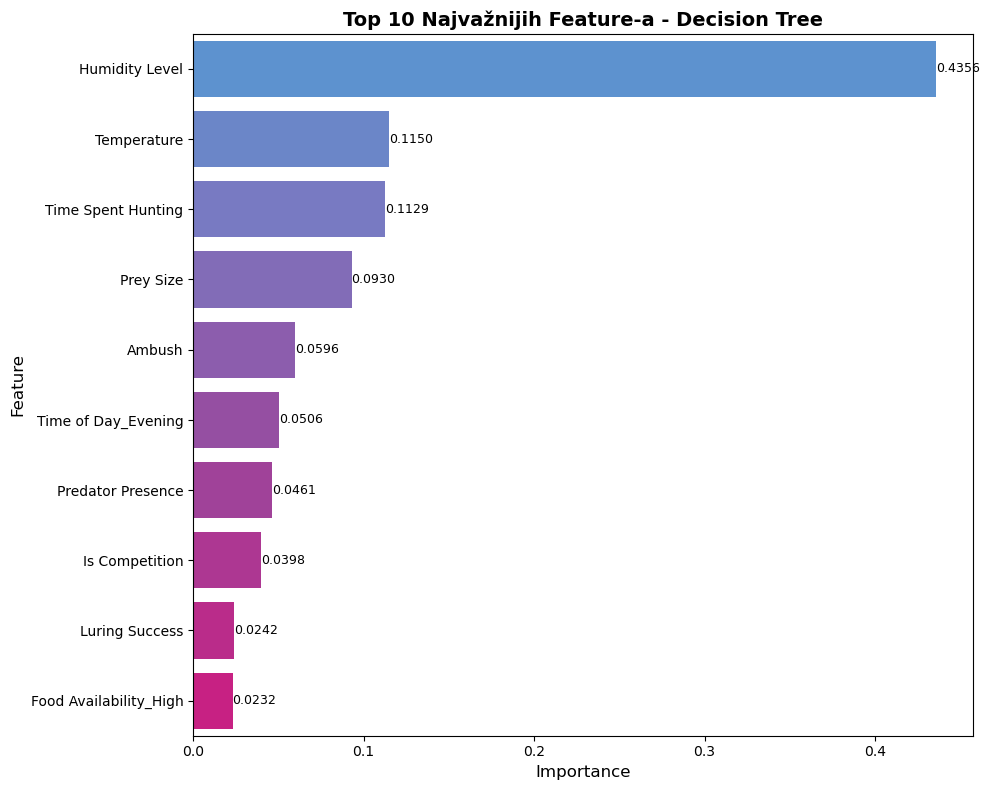

In [58]:
def plot_feature_importance(model, model_name, feature_names, top_n=10):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=feature_importance,
        y='Feature',
        x='Importance',
        palette=custom_palette
    )
    
    for i, (idx, row) in enumerate(feature_importance.iterrows()):
        ax.text(row['Importance'], i, f'{row["Importance"]:.4f}',
                va='center', ha='left', fontsize=9)
    
    plt.title(f'Top {top_n} Najvažnijih Feature-a - {model_name}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
 
custom_palette = sns.color_palette(['#4A90E2', '#5B7FD8', '#6C6ECE', '#7D5FC4',
                                     '#8E50BA', '#9F41B0', '#B032A6', '#C1239C',
                                     '#D21492', '#E30588'])
 
models = {
    'Random Forest': best_rf,
    'LGBM': best_lgbm,
    'XGB': best_xgb,
    'Extra Trees': best_etc,
    'Decision Tree': best_dt
}
 
feature_importances = {}

for model_name, model in models.items():
    feature_importances[model_name] = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plot_feature_importance(model, model_name, X_train.columns)

### <b> 6.2 LIME analiza</b>

In [59]:
import numpy as np
import pandas as pd

rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

fn_mask_rf = (y_test == 1) & (rf_pred == 0)
fn_mask_xgb = (y_test == 1) & (xgb_pred == 0)

rng = np.random.default_rng(42)

fn_indices_rf = rng.choice(
    np.where(fn_mask_rf)[0],
    size=3,
    replace=False
)

fn_indices_xgb = rng.choice(
    np.where(fn_mask_xgb)[0],
    size=3,
    replace=False
)

In [60]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=["Neuspešan lov", "Uspešan lov"],
    mode="classification",
    discretize_continuous=True
)

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lime_on_axis(exp, ax, title, confidence):
    features, weights = zip(*exp.as_list())
    y_pos = np.arange(len(features))

    colors = ["green" if w > 0 else "red" for w in weights]

    ax.barh(y_pos, weights, color=colors)
    ax.set_xlim(min(weights)*1.2, max(weights)*1.2)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.invert_yaxis()

    ax.set_title(
        f"{title}\nSigurnost modela: {confidence:.1f}%",
        fontsize=11
    )

    for i, w in enumerate(weights):
        ax.text(
            w + (0.01 if w > 0 else -0.01),
            i,
            f"{w:.2f}",
            va="center",
            ha="left" if w > 0 else "right",
            fontsize=8
        )

def plot_instance_table(ax, instance, title):
    ax.axis("off")

    table_data = [
        [col, f"{instance[col]:.3f}"] for col in instance.index
    ]

    table = ax.table(
        cellText=table_data,
        colLabels=["Feature", "Vrednost"],
        loc="center",
        cellLoc="left"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.3)

    ax.set_title(title, fontsize=11)

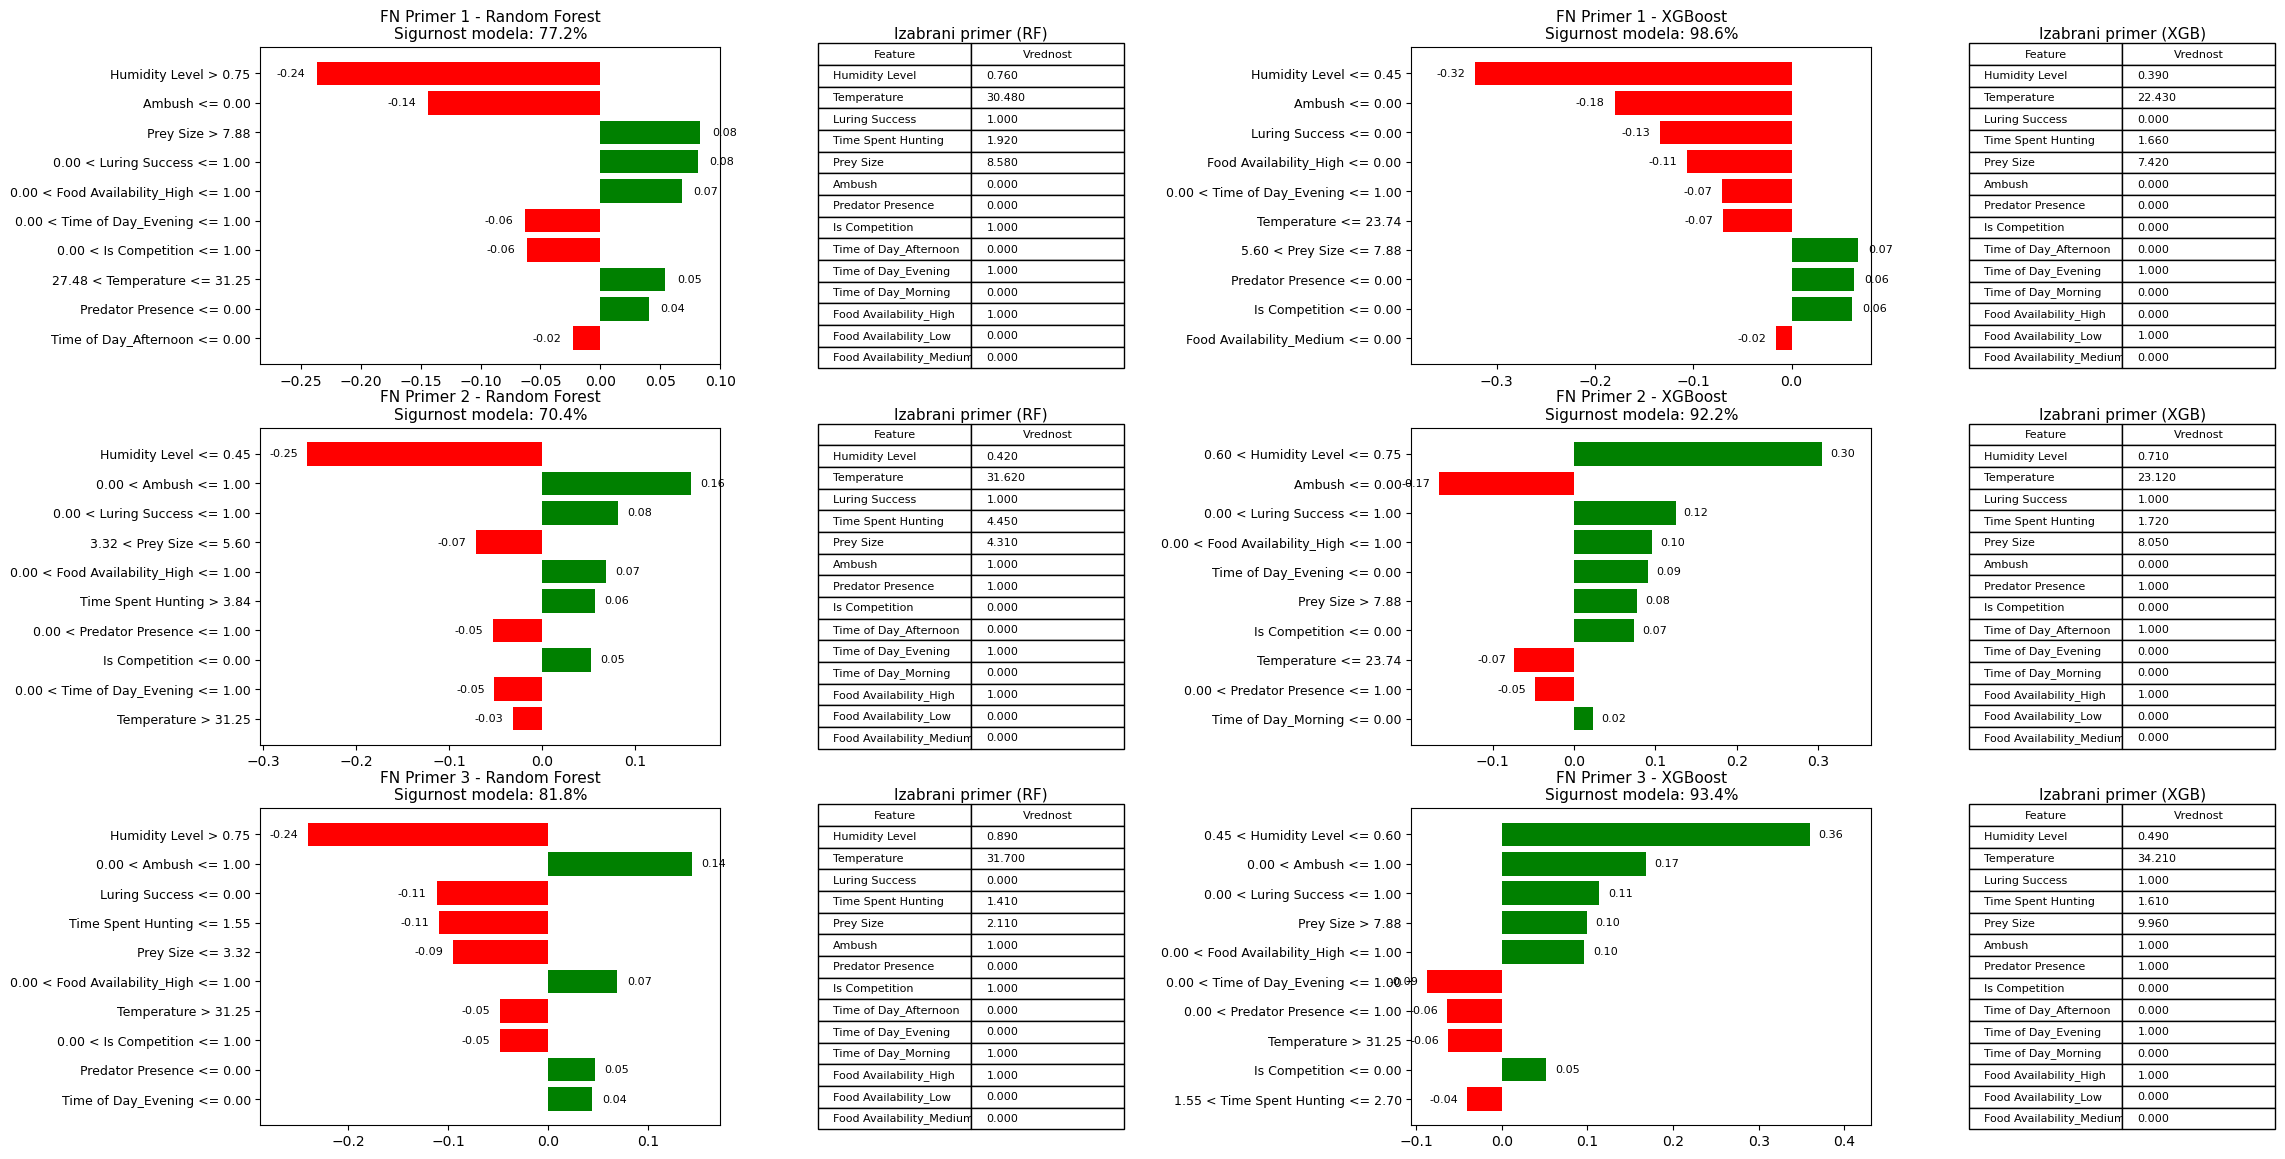

In [62]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(26, 14))
gs = gridspec.GridSpec(
    3, 5,
    width_ratios=[3, 2, 0.6, 3, 2], 
    wspace=0.3
)

for row in range(3):

    ax_rf_lime  = fig.add_subplot(gs[row, 0])
    ax_rf_table = fig.add_subplot(gs[row, 1])
    ax_xgb_lime = fig.add_subplot(gs[row, 3])
    ax_xgb_tab  = fig.add_subplot(gs[row, 4])

    fn_example_rf = X_test.iloc[fn_indices_rf[row]]

    proba_rf = best_rf.predict_proba(
        fn_example_rf.to_frame().T
    )[0]
    confidence_rf = proba_rf[0] * 100

    exp_rf = explainer.explain_instance(
        fn_example_rf.values,
        best_rf.predict_proba,
        num_features=10
    )

    plot_lime_on_axis(
        exp_rf,
        ax_rf_lime,
        title=f"FN Primer {row+1} - Random Forest",
        confidence=confidence_rf
    )

    plot_instance_table(
        ax_rf_table,
        fn_example_rf,
        title="Izabrani primer (RF)"
    )

    fn_example_xgb = X_test.iloc[fn_indices_xgb[row]]

    proba_xgb = best_xgb.predict_proba(
        fn_example_xgb.to_frame().T
    )[0]
    confidence_xgb = proba_xgb[0] * 100

    exp_xgb = explainer.explain_instance(
        fn_example_xgb.values,
        best_xgb.predict_proba,
        num_features=10
    )

    plot_lime_on_axis(
        exp_xgb,
        ax_xgb_lime,
        title=f"FN Primer {row+1} - XGBoost",
        confidence=confidence_xgb
    )

    plot_instance_table(
        ax_xgb_tab,
        fn_example_xgb,
        title="Izabrani primer (XGB)"
    )

plt.subplots_adjust(wspace=0.8)
plt.show()

<i> Zapažanje: XGBoost pokazuje veću sigurnost u predikcijama (oslanjao se previše na dominantne fičere - Humidity level i Ambush), za razliku od Random Forest-a koji se oslanjao na širi skup fičera pa je bio nesigurniji 

### <b> 6.3 SHAP </b>

XGB


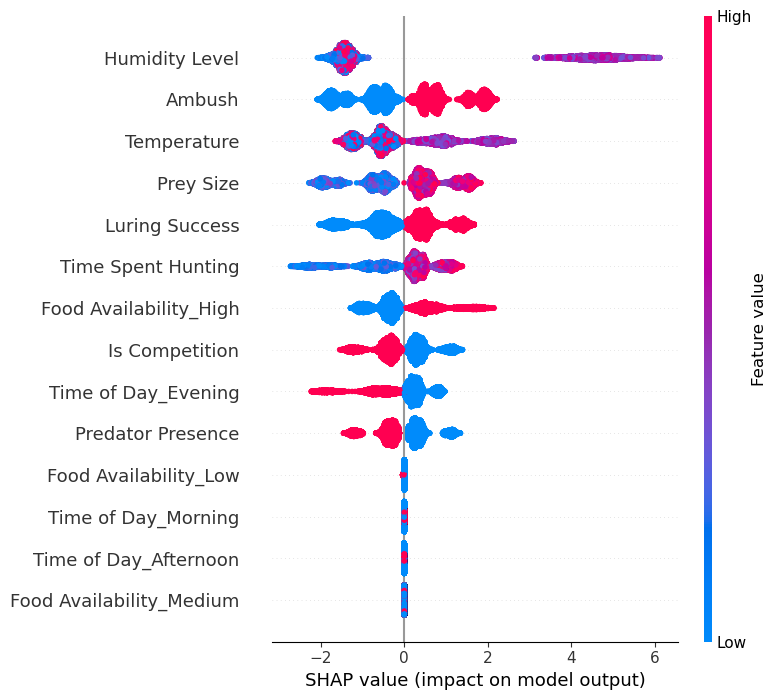

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

explainer = shap.Explainer(best_xgb)

shap_values = explainer(X_test)
print("XGB")
shap.summary_plot(shap_values, X_test)

Random Forest


 99%|===================| 994/1000 [01:09<00:00]        

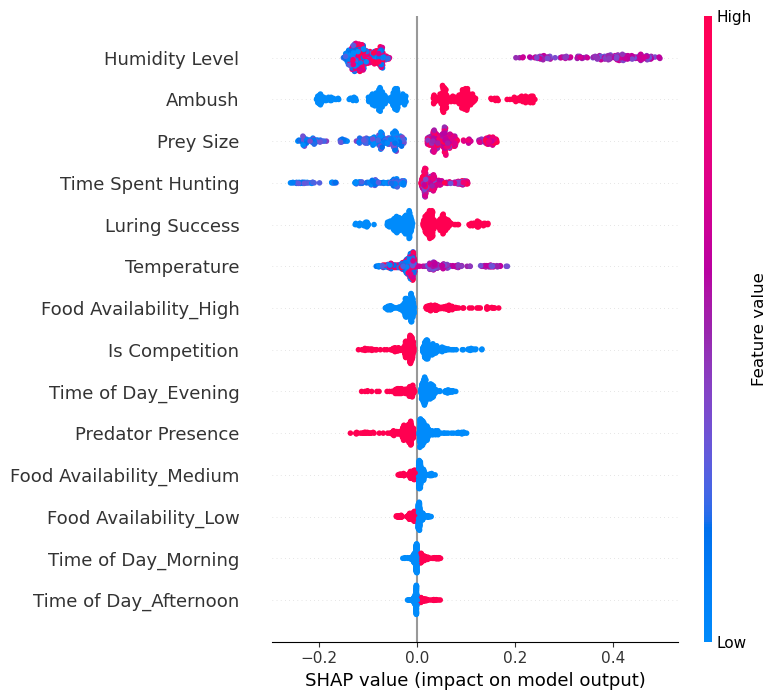

In [64]:
print("Random Forest")

import shap
import matplotlib.pyplot as plt

X_test_sample = X_test.sample(500, random_state=42)
 
explainer_rf = shap.Explainer(
    best_rf,
    X_train
)
 
sv = explainer_rf(
    X_test_sample,
    check_additivity=False
)
 
sv_pos = sv[..., 1]
 
plt.figure(figsize=(14, 10))
shap.summary_plot(
    sv_pos,
    X_test_sample,          
    max_display=X_test.shape[1], 
    show=False
)
 
plt.tight_layout()
plt.show()

## <b> 7. Redukcija dimenzionalnosti </b>
 
U ovoj sekciji analiziramo uticaj redukcije dimenzionalnosti na performanse modela. Testirane su tri metode:
- **SelectKBest** - selekcija na osnovu F-statistike (ručno definisan k)
- **RFECV** (Recursive Feature Elimination with CV) - automatski pronalazi optimalan broj features
- **PCA** (Principal Component Analysis) - transformacija u prostor glavnih komponenti

### <b> 7.1. Baseline rezultati i testiranje metoda redukcije </b>
 
Prvo prikazujemo rezultate sa svim feature-ima (baseline), a zatim testiramo različite metode redukcije:
- SelectKBest sa k = 8, 10, 12
- RFECV koji automatski pronalazi optimalan broj features za svaki model
- PCA sa n_components = 8, 10, 12

#### <b> 7.1.1 Baseline rezultati </b>
 
Prvo evaluiramo sve modele sa svim originalnim feature-ima da bismo imali referentne vrednosti za poređenje.

In [65]:
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.pipeline import Pipeline
 
def evaluate_dimensionality_reduction(X_tr, y_tr, X_te, y_te, model_name, method_name, model, selector):
 
    pipeline = Pipeline([
        ('selector', selector),
        ('classifier', clone(model))
    ])
 
    pipeline.fit(X_tr, y_tr)
 
    test_acc = pipeline.score(X_te, y_te)
    test_f1 = f1_score(y_te, pipeline.predict(X_te), average='weighted')
    n_feat = getattr(selector, 'n_features_', None)
 
    if n_feat is None:
        if hasattr(selector, "get_support"):
            n_feat = selector.get_support().sum()
        elif hasattr(selector, "n_components_"):
            n_feat = selector.n_components_
        elif hasattr(selector, "n_components"):
            n_feat = selector.n_components
    else:
        n_feat = None
    return {
        'Model': model_name,
        'Method': method_name,
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Test F1': f"{test_f1*100:.2f}%",
        'N Features': n_feat
    }
 
results = []
 
models_for_reduction = {
    'XGB': best_xgb,
    'Random Forest': best_rf
}
 
model_to_column = {
    'XGB': 'XGB - Optimized',
    'Random Forest': 'Random Forest - Optimized'
}
 
for model_name, model in models_for_reduction.items():
    col_name = model_to_column[model_name]
    test_acc = f"{result_df.loc['Accuracy', col_name]:.2f}%"
    test_f1  = f"{result_df.loc['F1-Score_Weighted', col_name]:.2f}%"
    results.append({
        'Model': model_name,
        'Method': 'Baseline (All Features)',
        'Test Accuracy': test_acc,
        'Test F1': test_f1,
        'N Features': X_train.shape[1]
    })
 
baseline_df = pd.DataFrame(results).set_index('Model')
display(baseline_df)

,Method,Test Accuracy,Test F1,N Features
Model,,,,
XGB,Baseline (All Features),97.19%,97.18%,14
Random Forest,Baseline (All Features),97.19%,97.18%,14


#### <b> 7.1.2 Testiranje metoda redukcije </b>
 
Testiramo tri metode redukcije dimenzionalnosti:
- **SelectKBest** - selekcija k najboljih feature-a na osnovu f_classif statistike
- **RFECV** - rekurzivna eliminacija feature-a sa cross-validacijom (automatski pronalazi optimalan broj)
- **PCA** - redukcija dimenzionalnosti pomoću Principal Component Analysis
 
Testiramo za broj feature-a: **8, 10, 12**

In [66]:
from sklearn.decomposition import PCA
n_features_list = [8, 10, 12]
total_features = X_train.shape[1]
 
for k in n_features_list:
    if k <= total_features:
        for model_name, model in models_for_reduction.items():
            selector = SelectKBest(score_func=f_classif, k=k)
            result = evaluate_dimensionality_reduction(
                X_train, y_train, X_test, y_test,
                model_name, f"SelectKBest (k={k})", model, selector
            )
            results.append(result)
 
rfecv_results = {}
for model_name, model in models_for_reduction.items():
    try:
        rfecv_estimator = clone(model)
 
        rfecv = RFECV(
            estimator=rfecv_estimator,
            step=2,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring="f1_weighted",
            n_jobs=1,
            min_features_to_select=3,
            importance_getter="auto"
        )
        rfecv.fit(X_train, y_train)
 
        optimal_n = rfecv.n_features_
        selected_features = X_train.columns[rfecv.support_].tolist()
 
        rfecv_results[model_name] = {
            "optimal_n": optimal_n,
            "selected_features": selected_features,
            "cv_scores": rfecv.cv_results_["mean_test_score"]
        }
 
        Xtr_sel = rfecv.transform(X_train)
        Xte_sel = rfecv.transform(X_test)
 
        final_model = clone(model)
        final_model.fit(Xtr_sel, y_train)
 
        test_acc = final_model.score(Xte_sel, y_test)
        test_f1 = f1_score(y_test, final_model.predict(Xte_sel), average="weighted")
 
        results.append({
            "Model": model_name,
            "Method": f"RFECV (n={optimal_n})",
            "Test Accuracy": f"{test_acc*100:.2f}%",
            "Test F1": f"{test_f1*100:.2f}%",
            "N Features": optimal_n
        })
 
    except Exception as e:
        pass
 
for n in n_features_list:
    if n <= total_features:
        for model_name, model in models_for_reduction.items():
            selector = PCA(n_components=n, random_state=42)
            result = evaluate_dimensionality_reduction(
                X_train, y_train, X_test, y_test,
                model_name, f"PCA (n={n})", model, selector
            )
            results.append(result)
 
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by="Test Accuracy",
    key=lambda x: x.str.rstrip("%").astype(float),
    ascending=False
)

Heatmap

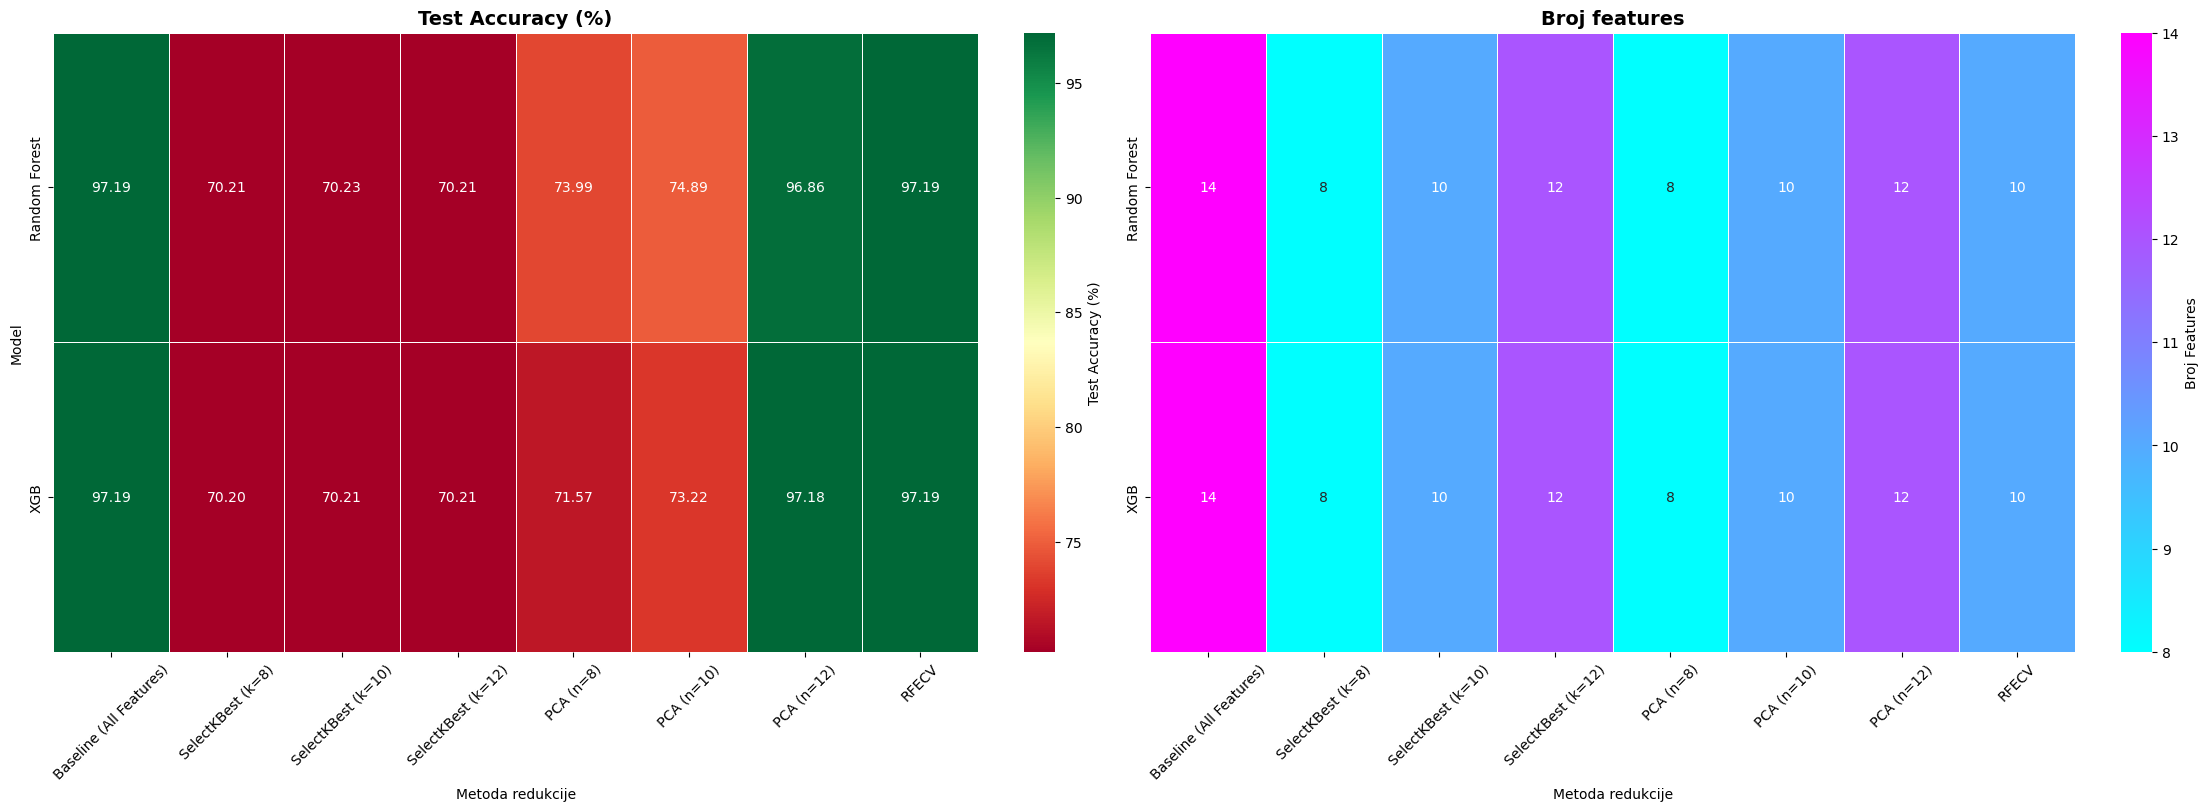

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
m = results_df.copy()
m['acc'] = m['Test Accuracy'].str.rstrip('%').astype(float)
 
m['Method_grouped'] = m['Method'].apply(lambda x: 'RFECV' if 'RFECV' in x else x)
 
pivot_acc = m.pivot_table(index='Model', columns='Method_grouped', values='acc', aggfunc='mean')
pivot_feat = m.pivot_table(index='Model', columns='Method_grouped', values='N Features', aggfunc='mean')
 
method_order = ['Baseline (All Features)']
for k in [8, 10, 12]:
    method_order.append(f'SelectKBest (k={k})')
for k in [8, 10, 12]:
    method_order.append(f'PCA (n={k})')
method_order.append('RFECV')
 
method_order = [c for c in method_order if c in pivot_acc.columns]
pivot_acc = pivot_acc[method_order]
pivot_feat = pivot_feat[[c for c in method_order if c in pivot_feat.columns]]
 
fig, axes = plt.subplots(1, 2, figsize=(22, 8), constrained_layout=True)
 
sns.heatmap(
    pivot_acc, annot=True, fmt='.2f', cmap='RdYlGn',
    linewidths=0.5, cbar_kws={'label': 'Test Accuracy (%)'}, ax=axes[0]
)
axes[0].set_title('Test Accuracy (%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Metoda redukcije')
axes[0].set_ylabel('Model')
axes[0].tick_params(axis='x', rotation=45)
 
sns.heatmap(
    pivot_feat, annot=True, fmt='.0f', cmap='cool',
    linewidths=0.5, cbar_kws={'label': 'Broj Features'}, ax=axes[1]
)
axes[1].set_title('Broj features', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Metoda redukcije')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=45)
 
plt.show()

**Grafici**

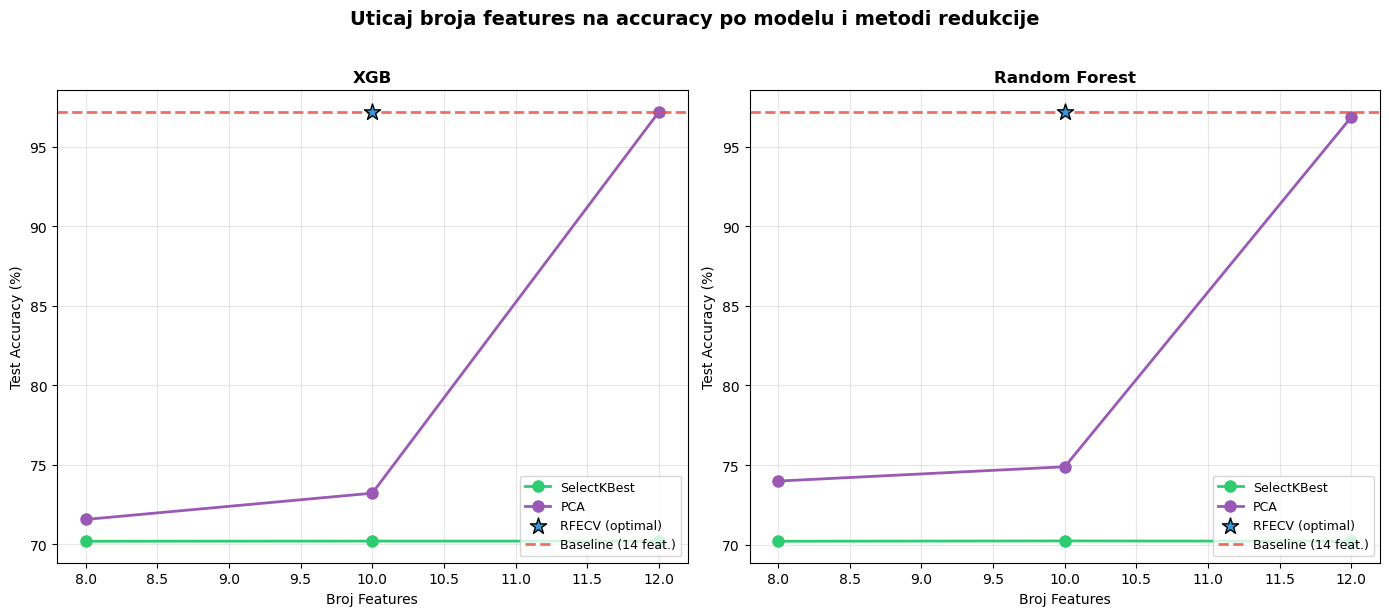

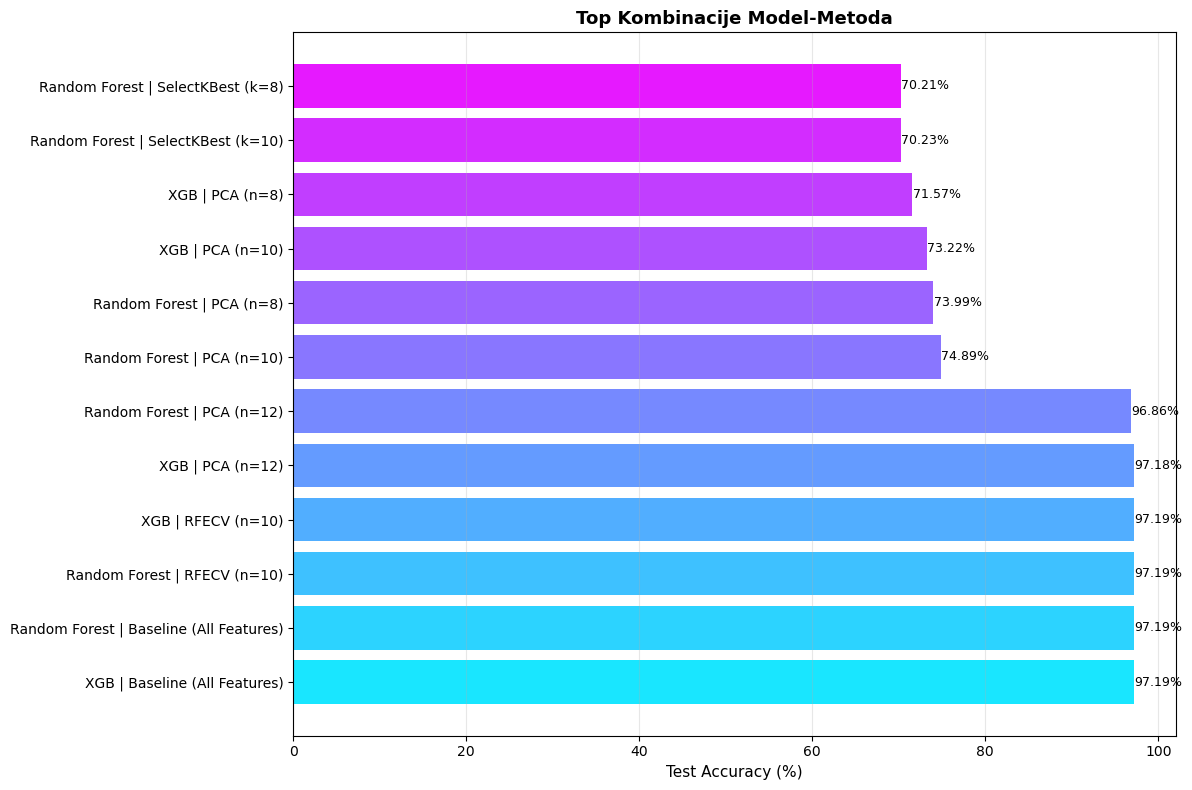

In [68]:
m = results_df.copy()
m['acc'] = m['Test Accuracy'].str.rstrip('%').astype(float)
m['Method Type'] = m['Method'].apply(lambda x: 'Baseline' if 'Baseline' in x else
                                                ('SelectKBest' if 'SelectKBest' in x else
                                                ('RFECV' if 'RFECV' in x else 'PCA')))
 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()
 
colors = {'SelectKBest': '#2ecc71', 'RFECV': '#3498db', 'PCA': '#9b59b6'}
 
for idx, model_name in enumerate(models_for_reduction.keys()):
    ax = axes[idx]
    model_data = m[m['Model'] == model_name]
    
    for method_type in ['SelectKBest', 'PCA']:
        method_data = model_data[model_data['Method Type'] == method_type].sort_values('N Features')
        if len(method_data) > 0:
            ax.plot(method_data['N Features'], method_data['acc'],
                   marker='o', linewidth=2, markersize=8,
                   label=method_type, color=colors[method_type])
    
    rfecv_data = model_data[model_data['Method Type'] == 'RFECV']
    if len(rfecv_data) > 0:
        ax.scatter(rfecv_data['N Features'], rfecv_data['acc'],
                  s=150, marker='*', color=colors['RFECV'],
                  label=f'RFECV (optimal)', zorder=5, edgecolors='black')
    
    baseline = model_data[model_data['Method Type'] == 'Baseline']
    if len(baseline) > 0:
        ax.axhline(baseline['acc'].iloc[0], color='#e74c3c', linestyle='--',
                  linewidth=2, label=f'Baseline ({baseline["N Features"].iloc[0]} feat.)', alpha=0.8)
    
    ax.set_xlabel('Broj Features', fontsize=10)
    ax.set_ylabel('Test Accuracy (%)', fontsize=10)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
 
plt.suptitle('Uticaj broja features na accuracy po modelu i metodi redukcije', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
 
fig, ax = plt.subplots(figsize=(12, 8))
 
top_methods = m.nlargest(min(12, len(m)), 'acc')
colors_bar = plt.cm.cool(np.linspace(0.1, 0.9, len(top_methods)))
bars = ax.barh(range(len(top_methods)), top_methods['acc'], color=colors_bar)
ax.set_yticks(range(len(top_methods)))
ax.set_yticklabels([f"{row['Model']} | {row['Method']}" for _, row in top_methods.iterrows()], fontsize=10)
ax.set_xlabel('Test Accuracy (%)', fontsize=11)
ax.set_title('Top Kombinacije Model-Metoda', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
 
for i, (_, row) in enumerate(top_methods.iterrows()):
    ax.text(row['acc'] + 0.02, i, f"{row['acc']:.2f}%", va='center', fontsize=9)
 
plt.tight_layout()
plt.show()

#### <b> 7.1.3 Analiza selektovanih features za najbolje kombinacije </b>
 
Za **top 4 kombinacija** modela i metoda redukcije dimenzionalnosti prikazujemo koje features su uključene, a koje odbačene. Ovo nam pomaže da razumemo koje varijable su najvažnije za predikciju i da li različiti modeli biraju slične features.

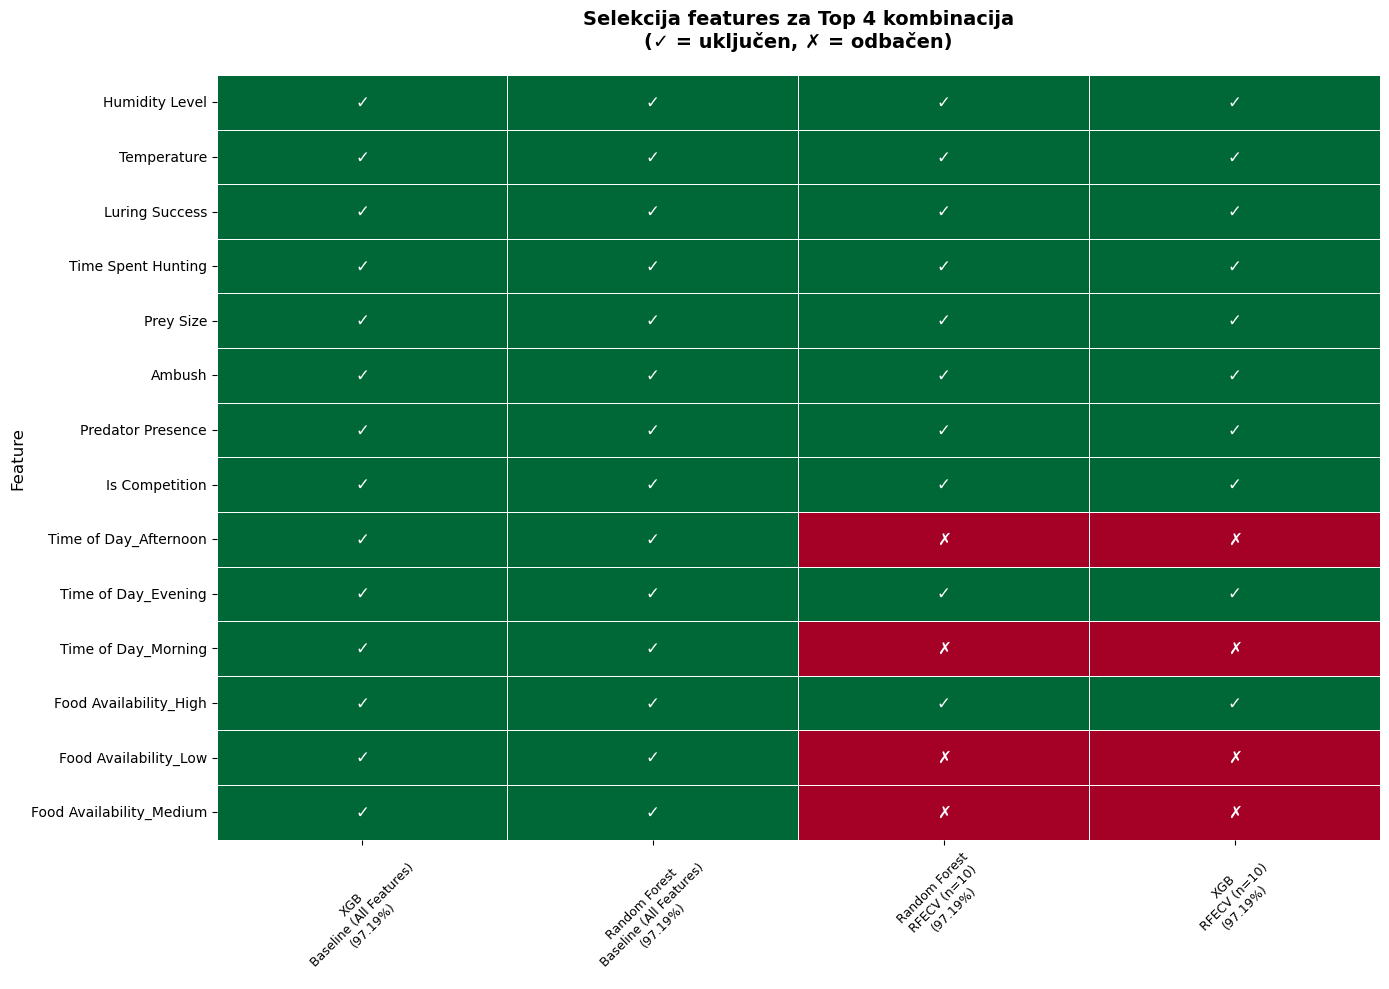

In [69]:
results_df['acc_float'] = results_df['Test Accuracy'].str.rstrip('%').astype(float)
top_4 = results_df.nlargest(4, 'acc_float')
 
all_features = X_train.columns.tolist()
 
feature_matrix = pd.DataFrame(index=all_features)
 
for idx, (_, row) in enumerate(top_4.iterrows()):
    model_name = row['Model']
    method = row['Method']
    col_name = f"{model_name}\n{method}\n({row['Test Accuracy']})"
    
    if 'Baseline' in method:
        feature_matrix[col_name] = ['✓'] * len(all_features)
    elif 'RFECV' in method and model_name in rfecv_results:
        selected = rfecv_results[model_name]['selected_features']
        feature_matrix[col_name] = ['✓' if f in selected else '✗' for f in all_features]
    elif 'PCA' in method:
        feature_matrix[col_name] = ['~'] * len(all_features)
    elif 'SelectKBest' in method:
        k = int(method.split('k=')[1].rstrip(')'))
        skb = SelectKBest(score_func=f_classif, k=k)
        skb.fit(X_train, y_train)
        selected_mask = skb.get_support()
        feature_matrix[col_name] = ['✓' if selected_mask[i] else '✗' for i in range(len(all_features))]
 
fig, ax = plt.subplots(figsize=(14, 10))
 
symbol_map = {'✓': 1, '✗': 0 }
numeric_matrix = feature_matrix.replace(symbol_map).astype(float)
 
sns.heatmap(
    numeric_matrix,
    annot=feature_matrix.values,
    fmt='',
    cmap='RdYlGn',
    cbar=False,
    linewidths=0.5,
    ax=ax,
    annot_kws={'fontsize': 12, 'fontweight': 'bold'}
)
 
ax.set_title('Selekcija features za Top 4 kombinacija\n(✓ = uključen, ✗ = odbačen)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Feature', fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=10)
 
plt.tight_layout()
plt.show()

## Zaključak
U ovom projektu rešavan je problem binarne klasifikacije na Chinese Mantis Hunting Dataset-u (~300.000 uzoraka) sa ciljem predviđanja uspešnosti lova bogomoljke.                                                                                                 
### Ključna zapažanja iz analize podataka:                                                                                           
- <b>Balansiranost dataseta</b> - Klase su približno jednako zastupljene (55% uspešan / 45% neuspešan lov), što eliminiše potrebu za tehnikama balansiranja.            
- <b>Outlieri</b> - Ekstremne vrednosti u kolonama Time Spent Hunting i Prey Size pokazuju viši success rate u odnosu na normalne vrednosti. Odlučeno je da se outlieri.
  ne uklanjaju jer predstavljaju validne, a ne pogrešne podatke - duže vreme lova i veći plen koreliraju sa većom uspešnošću. 
- <b>Performanse</b> - Već u baseline konfiguraciji modeli imaju jako dobre performanse (tačnost ~97%), dodatna      
  optimizacija hiperparametara nije značajnije unapredila rezultate, jer su performanse već pri gornjem limitu. 
- <b>Najuticajniji fičeri</b> - Stepen vlažnosti (Humidity Level), Zaseda (Ambush), Veličina plena (Prey Size), Vreme provedeno u lovu (Time Spent Hunting) i Temperatura (Temperature), gde se pritom posebno izdvojio fičer Stepen vlažnosti koji je imao najveću ulogu u donošenju odluke u izlazu modela.
- <b>Najbolji modeli</b> - Random Forest i XGBoost su se pokazali kao najbolji modeli.
- <b>Redukcija dimenzionalnosti</b> - Utvrđeno je da kategorije vezane za doba dana i dostupnost hrane - Time of Day_Afternoon, Time of Day_Morning, Food Availability_Medium i Food Availability_Low, imaju nizak značaj za predikciju. Eliminacijom ovih fičera postiže se optimizacija modela u pogledu memorije, vremena obrade i troškova prikupljanja podatak, bez gubitka performansi.
